# Assignment 2 MLP

*(Deep Learning (80240743), Spring 2023)*  
Due at **23:55, March 24, 2023**  


## Instructions

MNIST digits dataset is widely used for image classification in machine learning,  
consisting of 60000 (trainset) + 10000 (testset) grayscale images of handwritten  
digits from 0 to 9. Each image is a 28x28 bitmap, transformed into a flat vector  
of size 784 for our purpose.

In this assignment, you'll implement a Multi-Layer Perceptron (MLP) to perform  
MNIST classification. The same environment settings as in assignment 1 will be  
used to complete this assignment.

---

This file is divided into 4 sections:

1.  **Load Dataset**: ignore

2.  **Network Definitions**: This section holds most of your work. You'll complete  
    implentation of several neural network layers in this part. Most classes have  
    three methods: `__init__` used for parameter initialization, `forward` and  
    `backward` for forward and backward propagation respectively. Specifically, you  
    are asked to complete all the `TODO` parts.

3.  **Train**: The actual training part stays in this section. You can freely modify  
    the provided starting code. You'll need to play around with different hyperparameter  
    settings and observe their outcomes. Specifically,

    -   Record training and validation accuracy and plot their graphs.

    -   Compare how **Sigmoid** and **ReLU** perform differently as activation functions  
        through various aspects such as training time, convergence, accuray, etc.

    -   Compare how **Euclidean Loss** and **Softmax Cross Entropy Loss** perform  
        differently as loss functions through various aspects.

    -   Set up your own MLP model with two hidden layers (with number of hidden units  
        of your own choice), using any activation and loss function. Also, compare the  
        difference of results between one-layer structure and two-layer structure.

    -   The provided hyperparameters might not perform too well. Modify them and  
        observe how they affect classification performance.

4.  **Report**: Report your findings from previous section here. Supply your report with  
    data and graphs if necessary.

---

A few things to note:

-   Strive for efficient implementation. Avoid explicit for-loops where matrix multiplication  
    could be used.

-   Any neural network framework such as TensorFlow, PyTorch, etc. are **prohibited** in  
    finishing this assignment except for data preprocessing.

-   Cheating/Plagiarism will not be tolerated. Should any submission be found cheating or  
    containing plagiarism, a grade of zero will be given at minimum, and further consequences  
    may arise depending on the circumstances.

-   Late submissions will be deducted by 10% for each day (24h) late in the final grade. 

-   Broken/Incomplete submissions will be graded as-is. Please double check your uploads.


## 1. Load Dataset


In [1]:
import os
import pathlib
import requests
import tqdm
import numpy as np
import gzip
import matplotlib.pyplot as plt
from copy import deepcopy
from pdb import set_trace as st
%matplotlib inline

# for debugging
def dbprint(s):
    #print(s)
    pass


In [2]:
# Download dataset from Yann's website

train_images_filename = 'train-images-idx3-ubyte.gz'
train_labels_filename = 'train-labels-idx1-ubyte.gz'
test_images_filename = 't10k-images-idx3-ubyte.gz'
test_labels_filename = 't10k-labels-idx1-ubyte.gz'
gzfilenames = [
    train_images_filename, train_labels_filename,
    test_images_filename, test_labels_filename]

for filename in gzfilenames:
    if not os.path.exists(filename):
        fileurl = f'http://yann.lecun.com/exdb/mnist/{filename}'
        print(f'Downloading from {fileurl} ...')
        r = requests.get(fileurl)
        with open(filename, 'wb') as f:
            _ = f.write(r.content)


In [3]:
# Read from dataset file

validation_size = 5000

def read_mnist_image_set(images_filename):
    with gzip.GzipFile(images_filename, 'rb') as gz:
        magic = int.from_bytes(gz.read(4), 'big')
        assert magic == 2051, f'Not an MNIST image set'

        num_images = int.from_bytes(gz.read(4), 'big')
        rows = int.from_bytes(gz.read(4), 'big')
        cols = int.from_bytes(gz.read(4), 'big')

        data = np.frombuffer(gz.read(num_images * rows * cols), dtype=np.uint8)
        data = np.reshape(data, (num_images, rows, cols))
        return data

def read_mnist_label_set(labels_filename):
    with gzip.GzipFile(labels_filename, 'rb') as gz:
        magic = int.from_bytes(gz.read(4), 'big')
        assert magic == 2049, f'Not an MNIST label set'

        num_labels = int.from_bytes(gz.read(4), 'big')
        labels = np.frombuffer(gz.read(num_labels), dtype=np.uint8)
        return labels

print('\nLoading train set ...')
train_data = read_mnist_image_set(train_images_filename) / np.float32(255)
train_labels = read_mnist_label_set(train_labels_filename)
train_data, val_data = train_data[:-validation_size], train_data[-validation_size:]
train_labels, val_labels = train_labels[:-validation_size], train_labels[-validation_size:]
print(f'train_data: <np.array of shape: {train_data.shape} dtype: {train_data.dtype}>')
print(f'train_labels: <np.array of shape: {train_labels.shape} dtype: {train_labels.dtype}>')
print(f'val_data: <np.array of shape: {val_data.shape} dtype: {val_data.dtype}>')
print(f'val_labels: <np.array of shape: {val_labels.shape} dtype: {val_labels.dtype}>')

print('\nLoading test set ...')
test_data = read_mnist_image_set(test_images_filename) / np.float32(255)
test_labels = read_mnist_label_set(test_labels_filename)
print(f'test_data: <np.array of shape: {test_data.shape} dtype: {test_data.dtype}>')
print(f'test_labels: <np.array of shape: {test_labels.shape} dtype: {test_labels.dtype}>')



Loading train set ...
train_data: <np.array of shape: (55000, 28, 28) dtype: float32>
train_labels: <np.array of shape: (55000,) dtype: uint8>
val_data: <np.array of shape: (5000, 28, 28) dtype: float32>
val_labels: <np.array of shape: (5000,) dtype: uint8>

Loading test set ...
test_data: <np.array of shape: (10000, 28, 28) dtype: float32>
test_labels: <np.array of shape: (10000,) dtype: uint8>


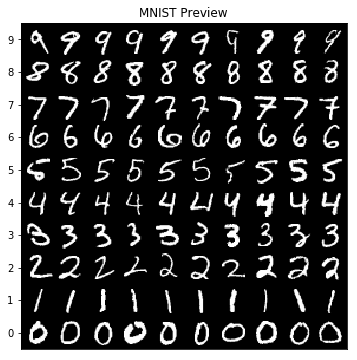

In [4]:
# Preview dataset

_ = plt.figure(figsize=(6, 6))
_ = plt.title('MNIST Preview')
for label in range(10):
    for img_index, img_data in enumerate(test_data[test_labels == label][:10]):
        _ = plt.imshow(
            img_data, 'gray',
            interpolation='nearest', extent=[img_index, img_index + 1, label, label + 1])
_ = plt.xticks([])
_ = plt.yticks(np.arange(10) + 0.5, range(10))
_ = plt.xlim(0, 10)
_ = plt.ylim(0, 10)

## 2. Network Definitions

In [5]:
class Network():
    ''' A simple neural network model with sequential layers '''
    def __init__(self):
        self.layerList = []
        self.numLayer = 0

    def add(self, layer):
        self.numLayer += 1
        self.layerList.append(layer)

    def forward(self, x):
        # forward layer by layer
        for i in range(self.numLayer):
            x = self.layerList[i].forward(x)
        return x

    def backward(self, delta):
        # backward layer by layer
        for i in reversed(range(self.numLayer)): # reversed
            delta = self.layerList[i].backward(delta)


### 2.1 `SGD` Stochastic gradient descent


In [6]:
class SGD():
    def __init__(self, learningRate, weightDecay):
        self.learningRate = learningRate
        self.weightDecay = weightDecay

    # One backpropagation step, update weights layer by layer
    def step(self, model):
        layers = model.layerList
        for layer in layers:
            if layer.trainable:
                
#                 if (layer.num_input, layer.num_output) == (784,128):
#                     continue
                
                ############################################################################
                # TODO: Put your code here
                # Calculate diff_W and diff_b using layer.grad_W and layer.grad_b.
                # Do not forget the weightDecay term.
                layer.diff_W = -1 * self.learningRate * (
                    layer.grad_W + 
                    self.weightDecay * (layer.W)
                )
                layer.diff_b = -1 * self.learningRate * (
                    layer.grad_b
                )
                
                ############################################################################

                layer.W += layer.diff_W
                layer.b += layer.diff_b


### 2.2 `FCLayer`

`FCLayer` treats each input as a simple column vector (reshape if necessary) and  
produces an output vector by doing matrix multiplication with weights and then adding  
biases:

$$
\mathbf{u} = \mathbf{W} \mathbf{x} + \mathbf{b}
$$

In [7]:
class FCLayer():
    ''' Fully Connected Layer '''
    def __init__(self, num_input, num_output, actFunction='relu', trainable=True):
        '''
        Apply a linear transformation to the incoming data: y = Wx + b
        Args:
            num_input: size of each input sample
            num_output: size of each output sample
            actFunction: the name of the activation function such as 'relu', 'sigmoid'
            trainable: whether if this layer is trainable
        '''
        self.num_input = num_input
        self.num_output = num_output
        self.trainable = trainable
        self.actFunction = actFunction
        assert actFunction in ['relu', 'sigmoid']

        self.XavierInit()

        self.grad_W = np.zeros((num_input, num_output))
        self.grad_b = np.zeros((1, num_output))


    def forward(self, x):

        ############################################################################
        # TODO: Put your code here
        # Apply linear transformation(Wx+b) to Input, and return results.

        dbprint(f'forward on fc layer {self.num_input}-{self.num_output}, x is {np.sum(x)}')
        self.u = x
        return np.matmul(x, self.W) + self.b
        ############################################################################


    def backward(self, delta):
        # The delta of this layer has been calculated in the later layer.
        ############################################################################
        # TODO: Put your code here
        # Calculate the gradient using the later layer's gradient: delta

        # self.grad_W and self.grad_b will be used in optimizer.py
        
        self.grad_b = np.mean(delta,0).reshape(self.b.shape)
        self.grad_W = np.matmul(delta.transpose(),self.u).transpose()
        
        dbprint(f'backward called on fc layer {self.num_input}-{self.num_output}, delta is {np.sum(delta)}, grad_W is {np.sum(self.grad_W)}')
        
        if (self.num_input, self.num_output) == (784,128):
            #st()
            pass
        
        new_delta = np.matmul(self.W,delta.transpose()).transpose()
        return new_delta
        ############################################################################


    def XavierInit(self):
        # Initialize the weigths according to the type of activation function.
        raw_std = (2 / (self.num_input + self.num_output))**0.5
        if 'relu' == self.actFunction:
            init_std = raw_std * (2**0.5)
        elif 'sigmoid' == self.actFunction:
            init_std = raw_std
        else:
            init_std = raw_std # * 4

        self.W = np.random.normal(0, init_std, (self.num_input, self.num_output))
        self.b = np.random.normal(0, init_std, (1, self.num_output))


### 2.3 `SigmoidLayer`

`SigmoidLayer` is a sigmoid activation unit, computing the output as

$$
f(\mathbf{u}) = \frac{1}{1 + \exp(-\mathbf{u})}
$$

In [8]:
class SigmoidLayer():
    ''' Sigmoid Layer '''
    def __init__(self):
        '''
        Applies the element-wise function: f(x) = 1/(1+exp(-x))
        '''
        self.trainable = False

    def forward(self, x):

        ############################################################################
        # TODO: Put your code here
        # Apply Sigmoid activation function to Input, and return results.
        
        self.first_x = x
        self.y = 1 / (1 + np.exp(-x))

        return self.y
        ############################################################################

    def backward(self, delta):

        ############################################################################
        # TODO: Put your code here
        # Calculate the gradient using the later layer's local sensitivity: delta
        dbprint(f'backward called on sigmoid, delta is {np.sum(delta)}')

        return np.multiply(delta, np.multiply(self.y, 1-self.y))
        #return np.matmul(np.matmul(1-self.y, self.y.transpose()), delta)
        ############################################################################


### 2.4 `ReLULayer`

`ReLULayer` is a linear rectified unit, computing the output as

$$
f(\mathbf{u}) = \max(\mathbf{0}, \mathbf{u})
$$

In [9]:
class ReLULayer():
    ''' ReLU Layer '''
    def __init__(self):
        '''
        Applies the rectified linear unit function element-wise: relu(x) = max(x, 0)
        '''
        self.trainable = False # no parameters

    def forward(self, x):

        ############################################################################
        # TODO: Put your code here
        # Apply ReLU activation function to Input, and return results.

        self.y = np.maximum(0, x)
        return self.y
        ############################################################################


    def backward(self, delta):

        ############################################################################
        # TODO: Put your code here
        # Calculate the gradient using the later layer's local sensitivity: delta
        
        return np.multiply(delta, 1 * (self.y > 0))
        ############################################################################


### 2.5 `EuclideanLossLayer`

`EuclideanLossLayer` computes the sum of squares of differences between  
inputs and labels:

$$
\frac{1}{2} \sum_{n} \lVert \operatorname{logits}(n) - \operatorname{label}(n) \rVert _2^2
$$

In [10]:
class EuclideanLossLayer():
    ''' Euclidean Loss Layer '''
    def __init__(self):
        self.accu = 0.
        self.loss = 0.

    def forward(self, logit, gt):
        '''
          Inputs: (minibatch)
          - logit: forward results from the last FCLayer, shape(batch_size, 10)
          - gt: the ground truth label, shape(batch_size, 10)
        '''

        ############################################################################
        # TODO: Put your code here
        # Calculate the average accuracy and loss over the minibatch, and
        # store in self.accu and self.loss respectively.
        # Only return the self.loss, self.accu will be used in solver.py.
        
        self.y, self.t = logit, gt
        
        self.accu = np.mean(
            np.argmax(logit,1) == np.argmax(gt,1)
        )
        self.loss = (0.5 * np.sum(np.square(logit.flatten() - gt.flatten()))) / batch_size
        ############################################################################

        return self.loss

    def backward(self):

        ############################################################################
        # TODO: Put your code here
        # Calculate and return the gradient (have the same shape as logit)
        return self.y - self.t
        ############################################################################


### 2.6 `SoftmaxCrossEntropyLossLayer`

`SoftmaxCrossEntropyLossLayer` can be viewed as a mapping from input to a probability  
distribution in the following form:

$$
P(t_k=1\vert\mathbf{x}) = \frac{\exp(x_k)}{\sum_{j=1}^{K}\exp(x_j)}
$$

where $x_k$ is the $k$-th component in the input vector $\mathbf{x}$ and $P(t_k = 1|\mathbf{x})$ indicates the  
probability of being classified to class $k$ given the input. Since the output of softmax layer  
can be interpreted as a probability distribution, we can compute the delta likelihood and its  
logarithm form is also called cross entropy error function:

$$
E = -\ln p(t^{(1)}, \dots, t^{(N)}) = \sum_{n=1}^N E^{(n)}
$$

where

$$
E^{(n)} = -\sum_{k=1}^K t_k^{(n)} \ln h_k^{(n)}
$$

$$
h_k^{(n)} = P(t_k^{(n)}=1\vert \mathbf{x}^{(n)}) = \frac{\exp x_k^{(n)}}{\sum_{j=1}^K \exp x_j^{(n)}}
$$

The definition of the softmax loss layer is a little different from Assignment 1, since we don't  
include trainable parameters $\theta$ in this layer. However these parameters can be explicitly  
extracted out to form an individual `FCLayer`.

In [11]:
# a small number to prevent dividing by zero, maybe useful for you
EPS = 1e-11

class SoftmaxCrossEntropyLossLayer():
    ''' Softmax Cross-Entropy Loss Layer '''
    def __init__(self):
        self.accu = 0.
        self.loss = np.zeros(1, dtype='f')

    def forward(self, logit, gt):
        '''
          Inputs: (minibatch)
          - logit: forward results from the last FCLayer, shape(batch_size, 10)
          - gt: the ground truth label, shape(batch_size, 10)
        '''

        ############################################################################
        # TODO: Put your code here
        # Calculate the average accuracy and loss over the minibatch, and
        # store in self.accu and self.loss respectively.
        # Only return the self.loss, self.accu will be used in solver.py.
        
        logit = deepcopy(logit)
        
        for i in range(batch_size):
            logit[i,:] = np.exp(logit[i,:]) / np.sum(np.exp(logit[i,:]))
        
        self.y = logit
        self.t = gt
        
        self.accu = np.mean(
            np.argmax(logit,1) == np.argmax(gt,1)
        )
        
        total = 0
        lnhn = np.log(logit)
        for i in range(batch_size):
            total -= np.matmul(gt[i,:].transpose(), lnhn[i,:])
        self.loss = total / batch_size
        
        ############################################################################

        return self.loss


    def backward(self):

        ############################################################################
        # TODO: Put your code here
        # Calculate and return the gradient (have the same shape as logit)

        # get the delta value
        
        return self.y - self.t
        ############################################################################


## 3. Train

You may freely modify any given template code as you see fit.


In [12]:
# Hyperparameters

batch_size = 100
max_epoch = 8
init_std = 0.01

learning_rate_SGD = 0.0005#0.1
weight_decay = 0.001


In [13]:
def train(model, criterion, optimizer):
    all_train_losses, all_train_accs = [], []
    avg_train_losses, avg_train_accs = [], []
    avg_val_losses, avg_val_accs = [], []

    # Training process
    for epoch in range(max_epoch):
        # Train one epoch
        batch_train_losses, batch_train_accs = [], []

        steps_per_epoch = np.ceil(len(train_data) / batch_size).astype(int)
        batch_split_indices = np.arange(batch_size, len(train_data), batch_size)
        train_data_batches = np.split(train_data, batch_split_indices)
        train_labels_batches = np.split(train_labels, batch_split_indices)

        progress_bar = tqdm.tqdm(range(steps_per_epoch), desc=f'Ep[{epoch}]', position=0, leave=True)
        for step_index in progress_bar:
            # Get train data and label
            x = np.reshape(train_data_batches[step_index], (-1, 784))   # x.shape: [batch_size, 784]
            y_true = np.eye(10)[train_labels_batches[step_index]]       # y_true.shape (one-hot): [batch_size, 10]

            # Forward pass
            y_pred = model.forward(x)
            criterion.forward(y_pred, y_true)

            # Backward pass
            delta = criterion.backward()
            dbprint('calling backward')
            model.backward(delta)
            #dbprint('backward called on whole model and looks like '+str(np.sum(model.layerList[-3].grad_W)))
            
            # Update weights, see optimize.py
            optimizer.step(model)

            # Record loss and accuracy
            batch_train_losses.append(criterion.loss)
            batch_train_accs.append(criterion.accu)
            progress_bar.set_description(f'Ep[{epoch}] loss:{criterion.loss:.3f} acc:{criterion.accu:.3f}')

        # Validate
        # Get validating data and label
        x = np.reshape(val_data, (-1, 784)) # x.shape: [batch_size, 784]
        y_true = np.eye(10)[val_labels]     # y_true.shape (one-hot): [batch_size, 10]

        # Only forward pass
        y_pred = model.forward(x)
        criterion.forward(y_pred, y_true)

        # Record loss and accuracy
        val_loss = criterion.loss
        val_acc = criterion.accu

        all_train_losses.extend(batch_train_losses)
        all_train_accs.extend(batch_train_accs)
        avg_train_losses.append(np.mean(batch_train_losses))
        avg_train_accs.append(np.mean(batch_train_accs))
        avg_val_losses.append(np.mean(val_loss))
        avg_val_accs.append(np.mean(val_acc))
        print(f'Epoch {epoch} Val loss:{avg_val_losses[-1]:.4f} acc:{avg_val_accs[-1]:.4f}')
        #print(np.sum(np.square(model.layerList[-3].W)))

    # Test
    x = np.reshape(test_data, (-1, 784)) # x.shape: [batch_size, 784]
    y_true = np.eye(10)[test_labels]     # y_true.shape (one-hot): [batch_size, 10]

    # Only forward pass
    y_pred = model.forward(x)
    criterion.forward(y_pred, y_true)

    test_acc = criterion.accu
    print(f'\nTest acc is {test_acc:.4f}\n')

    # plot loss & accuracy curve
    x_by_epoch = (np.arange(max_epoch) + 1) * steps_per_epoch
    fig, (a0, a1) = plt.subplots(1, 2, figsize=(12, 4))
    _ = a0.set_title('Losses')
    # _ = a0.plot(all_train_losses, alpha=0.5, label='train (all)')
    _ = a0.plot(x_by_epoch, avg_train_losses, marker='.', label='train')
    _ = a0.plot(x_by_epoch, avg_val_losses, marker='.', label='val')
    _ = a0.legend()
    _ = a1.set_title('Accuracies')
    # _ = a1.plot(all_train_accs, alpha=0.5, label='train (all)')
    _ = a1.plot(x_by_epoch, avg_train_accs, marker='.', label='train')
    _ = a1.plot(x_by_epoch, avg_val_accs, marker='.', label='val')
    _ = a1.legend()

    return model, avg_val_losses, avg_val_accs


Ep[1] loss:0.209 acc:0.830:   4%|███▋                                                                                     | 23/550 [00:00<00:02, 225.49it/s]

Epoch 0 Val loss:10.6409 acc:0.8784


Ep[2] loss:0.191 acc:0.850:   4%|███▌                                                                                     | 22/550 [00:00<00:02, 217.82it/s]

Epoch 1 Val loss:9.8904 acc:0.8880


Ep[3] loss:0.200 acc:0.880:   5%|████                                                                                     | 25/550 [00:00<00:02, 238.12it/s]

Epoch 2 Val loss:9.4161 acc:0.8924


Ep[4] loss:0.190 acc:0.870:   5%|████                                                                                     | 25/550 [00:00<00:02, 245.10it/s]

Epoch 3 Val loss:8.9906 acc:0.8956


Ep[5] loss:0.195 acc:0.850:   4%|███▋                                                                                     | 23/550 [00:00<00:02, 223.30it/s]

Epoch 4 Val loss:8.5797 acc:0.8968


Ep[6] loss:0.174 acc:0.870:   4%|███▌                                                                                     | 22/550 [00:00<00:02, 219.99it/s]

Epoch 5 Val loss:8.1745 acc:0.8994


Ep[7] loss:0.154 acc:0.920:   4%|███▌                                                                                     | 22/550 [00:00<00:02, 213.59it/s]

Epoch 6 Val loss:7.7718 acc:0.9026


Ep[7] loss:0.221 acc:0.800: 100%|████████████████████████████████████████████████████████████████████████████████████████| 550/550 [00:02<00:00, 233.64it/s]


Epoch 7 Val loss:7.3739 acc:0.9064

Test acc is 0.8932



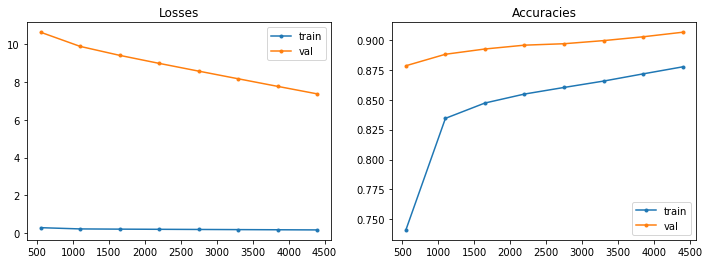

In [14]:
# Build MLP with FCLayer and SigmoidLayer
# 128 is the number of hidden units, you can change by your own
mlp_sigmoid_euclidean = Network()
mlp_sigmoid_euclidean.add(FCLayer(784, 128, actFunction='sigmoid'))
mlp_sigmoid_euclidean.add(SigmoidLayer())
mlp_sigmoid_euclidean.add(FCLayer(128, 10, actFunction='sigmoid'))

criterion_euclidean = EuclideanLossLayer()
sgd = SGD(learning_rate_SGD, weight_decay)

mlp_sigmoid_euclidean, avg_val_losses, avg_val_accs = train(mlp_sigmoid_euclidean, criterion_euclidean, sgd)


Ep[1] loss:0.142 acc:0.890:   4%|███▋                                                                                     | 23/550 [00:00<00:02, 225.49it/s]

Epoch 0 Val loss:6.2027 acc:0.9258


Ep[2] loss:0.120 acc:0.900:   4%|███▋                                                                                     | 23/550 [00:00<00:02, 223.30it/s]

Epoch 1 Val loss:4.9089 acc:0.9430


Ep[3] loss:0.085 acc:0.950:   4%|███▌                                                                                     | 22/550 [00:00<00:02, 220.00it/s]

Epoch 2 Val loss:4.3426 acc:0.9482


Ep[4] loss:0.073 acc:0.980:   4%|███▋                                                                                     | 23/550 [00:00<00:02, 227.72it/s]

Epoch 3 Val loss:4.0047 acc:0.9540


Ep[5] loss:0.078 acc:0.950:   3%|███                                                                                      | 19/550 [00:00<00:02, 190.00it/s]

Epoch 4 Val loss:3.7688 acc:0.9562


Ep[6] loss:0.064 acc:0.990:   4%|███▏                                                                                     | 20/550 [00:00<00:02, 194.17it/s]

Epoch 5 Val loss:3.5947 acc:0.9600


Ep[7] loss:0.067 acc:0.960:   4%|███▍                                                                                     | 21/550 [00:00<00:02, 205.88it/s]

Epoch 6 Val loss:3.4554 acc:0.9610


Ep[7] loss:0.098 acc:0.930: 100%|████████████████████████████████████████████████████████████████████████████████████████| 550/550 [00:02<00:00, 210.41it/s]


Epoch 7 Val loss:3.3416 acc:0.9620

Test acc is 0.9494

[6.202688610395479, 4.908916729787934, 4.342600388747445, 4.004710575451494, 3.768819470011997, 3.594678074760275, 3.455426864517749, 3.3416445192616906] [0.9258, 0.943, 0.9482, 0.954, 0.9562, 0.96, 0.961, 0.962]


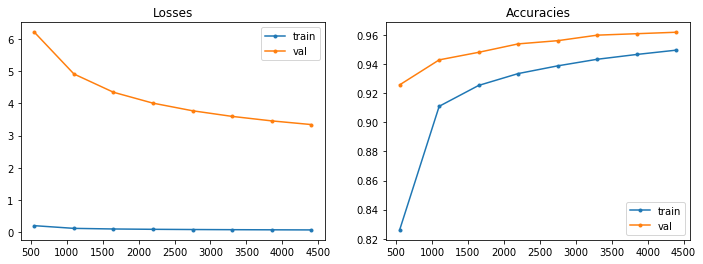

In [15]:
# Build mlp_relu_euclidean with FCLayer and ReLULayer
# 128 is the number of hidden units, you can change by your own
mlp_relu_euclidean = Network()
mlp_relu_euclidean.add(FCLayer(784, 128, actFunction='sigmoid'))
mlp_relu_euclidean.add(ReLULayer())
mlp_relu_euclidean.add(FCLayer(128, 10, actFunction='sigmoid'))

criterion_euclidean = EuclideanLossLayer()
sgd = SGD(learning_rate_SGD, weight_decay)

mlp_relu_euclidean, avg_val_losses, avg_val_accs = train(mlp_relu_euclidean, criterion_euclidean, sgd)
print(avg_val_losses, avg_val_accs)

Ep[0] loss:0.900 acc:0.740: 100%|████████████████████████████████████████████████████████████████████████████████████████| 550/550 [00:02<00:00, 187.52it/s]
C:\Users\thisi\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in log
Ep[1] loss:0.605 acc:0.870:   3%|██▉                                                                                      | 18/550 [00:00<00:02, 180.00it/s]

Epoch 0 Val loss:0.5210 acc:0.8932


Ep[2] loss:0.418 acc:0.870:   3%|██▉                                                                                      | 18/550 [00:00<00:03, 176.47it/s]

Epoch 1 Val loss:0.3873 acc:0.9124


Ep[3] loss:0.373 acc:0.910:   3%|███                                                                                      | 19/550 [00:00<00:02, 186.27it/s]

Epoch 2 Val loss:0.3436 acc:0.9188


Ep[4] loss:0.334 acc:0.920:   3%|██▉                                                                                      | 18/550 [00:00<00:02, 178.22it/s]

Epoch 3 Val loss:0.3207 acc:0.9242


Ep[5] loss:0.400 acc:0.870:   3%|██▉                                                                                      | 18/550 [00:00<00:03, 173.08it/s]

Epoch 4 Val loss:0.3052 acc:0.9264


Ep[6] loss:0.193 acc:0.950:   3%|███                                                                                      | 19/550 [00:00<00:02, 184.47it/s]

Epoch 5 Val loss:0.2930 acc:0.9292


Ep[7] loss:0.282 acc:0.920:   3%|██▌                                                                                      | 16/550 [00:00<00:03, 158.41it/s]

Epoch 6 Val loss:0.2824 acc:0.9312


Ep[7] loss:0.483 acc:0.860: 100%|████████████████████████████████████████████████████████████████████████████████████████| 550/550 [00:03<00:00, 181.04it/s]


Epoch 7 Val loss:0.2729 acc:0.9330

Test acc is 0.9190

[0.5209973121703244, 0.3872956726265173, 0.34355996226253166, 0.3207262379476298, 0.3052234125469458, 0.29295976611567237, 0.2824037277685237, 0.27289382942400214] [0.8932, 0.9124, 0.9188, 0.9242, 0.9264, 0.9292, 0.9312, 0.933]


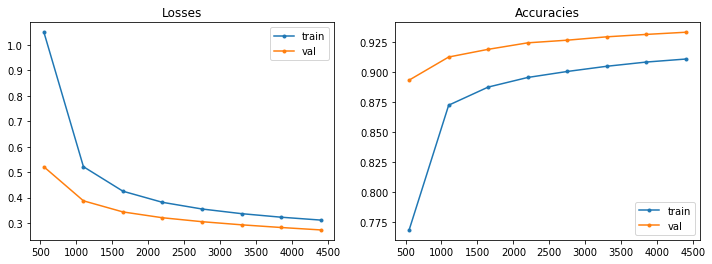

In [16]:
# Build MLP with FCLayer and SigmoidLayer
# 128 is the number of hidden units, you can change by your own
mlp_sigmoid_ce = Network()
mlp_sigmoid_ce.add(FCLayer(784, 128))
mlp_sigmoid_ce.add(SigmoidLayer())
mlp_sigmoid_ce.add(FCLayer(128, 10))

criterion_ce = SoftmaxCrossEntropyLossLayer()
sgd = SGD(learning_rate_SGD, weight_decay)

mlp_sigmoid_ce, avg_val_losses, avg_val_accs = train(mlp_sigmoid_ce, criterion_ce, sgd)
print(avg_val_losses, avg_val_accs)

Ep[0] loss:0.550 acc:0.830: 100%|████████████████████████████████████████████████████████████████████████████████████████| 550/550 [00:03<00:00, 178.75it/s]
C:\Users\thisi\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in log
Ep[1] loss:0.296 acc:0.920:   3%|██▉                                                                                      | 18/550 [00:00<00:02, 180.00it/s]

Epoch 0 Val loss:0.2882 acc:0.9344


Ep[2] loss:0.238 acc:0.950:   3%|███                                                                                      | 19/550 [00:00<00:02, 188.12it/s]

Epoch 1 Val loss:0.2311 acc:0.9488


Ep[3] loss:0.185 acc:0.960:   2%|██                                                                                       | 13/550 [00:00<00:04, 130.00it/s]

Epoch 2 Val loss:0.1983 acc:0.9550


Ep[4] loss:0.158 acc:0.970:   3%|██▉                                                                                      | 18/550 [00:00<00:02, 178.22it/s]

Epoch 3 Val loss:0.1744 acc:0.9582


Ep[5] loss:0.112 acc:0.970:   3%|██▌                                                                                      | 16/550 [00:00<00:03, 158.41it/s]

Epoch 4 Val loss:0.1553 acc:0.9614


Ep[6] loss:0.123 acc:0.980:   3%|██▊                                                                                      | 17/550 [00:00<00:03, 161.90it/s]

Epoch 5 Val loss:0.1373 acc:0.9630


Ep[7] loss:0.200 acc:0.950:   3%|██▌                                                                                      | 16/550 [00:00<00:03, 152.38it/s]

Epoch 6 Val loss:0.1224 acc:0.9644


Ep[7] loss:0.163 acc:0.950: 100%|████████████████████████████████████████████████████████████████████████████████████████| 550/550 [00:03<00:00, 160.35it/s]


Epoch 7 Val loss:0.1102 acc:0.9660

Test acc is 0.9592

[0.28815778687052357, 0.2311297999638789, 0.19828313092008276, 0.1744296138294837, 0.15528901871508366, 0.13726855524600742, 0.12239824245843606, 0.11018336550668792] [0.9344, 0.9488, 0.955, 0.9582, 0.9614, 0.963, 0.9644, 0.966]


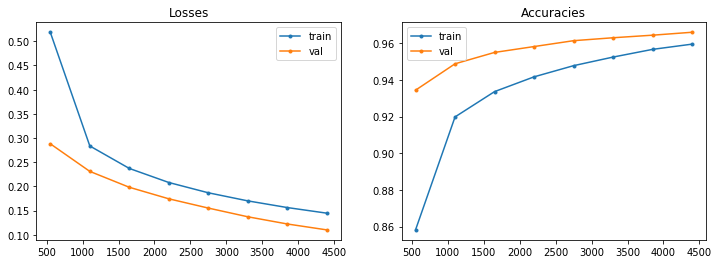

In [17]:
# Build mlp_relu_ce with FCLayer and ReLULayer
# 128 is the number of hidden units, you can change by your own
mlp_relu_ce = Network()
mlp_relu_ce.add(FCLayer(784, 128))
mlp_relu_ce.add(ReLULayer())
mlp_relu_ce.add(FCLayer(128, 10))

criterion_ce = SoftmaxCrossEntropyLossLayer()
sgd = SGD(learning_rate_SGD, weight_decay)

mlp_relu_ce, avg_val_losses, avg_val_accs = train(mlp_relu_ce, criterion_ce, sgd)
print(avg_val_losses, avg_val_accs)

Ep[0] loss:0.473 acc:0.850: 100%|████████████████████████████████████████████████████████████████████████████████████████| 550/550 [00:02<00:00, 203.40it/s]
C:\Users\thisi\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in log
Ep[1] loss:0.116 acc:0.980:   4%|███▏                                                                                     | 20/550 [00:00<00:02, 188.68it/s]

Epoch 0 Val loss:0.2173 acc:0.9330


Ep[2] loss:0.073 acc:0.990:   4%|███▏                                                                                     | 20/550 [00:00<00:02, 194.17it/s]

Epoch 1 Val loss:0.1672 acc:0.9496


Ep[3] loss:0.129 acc:0.970:   4%|███▏                                                                                     | 20/550 [00:00<00:02, 194.17it/s]

Epoch 2 Val loss:0.1376 acc:0.9588


Ep[4] loss:0.121 acc:0.980:   3%|███                                                                                      | 19/550 [00:00<00:02, 184.46it/s]

Epoch 3 Val loss:0.1201 acc:0.9610


Ep[5] loss:0.042 acc:0.990:   4%|███▍                                                                                     | 21/550 [00:00<00:02, 198.12it/s]

Epoch 4 Val loss:0.1071 acc:0.9646


Ep[6] loss:0.084 acc:0.990:   4%|███▏                                                                                     | 20/550 [00:00<00:02, 198.02it/s]

Epoch 5 Val loss:0.0952 acc:0.9656


Ep[7] loss:0.109 acc:0.950:   4%|███▏                                                                                     | 20/550 [00:00<00:02, 192.31it/s]

Epoch 6 Val loss:0.0847 acc:0.9666


Ep[7] loss:0.150 acc:0.960: 100%|████████████████████████████████████████████████████████████████████████████████████████| 550/550 [00:02<00:00, 197.70it/s]


Epoch 7 Val loss:0.0775 acc:0.9676

Test acc is 0.9623

[0.21734871070728928, 0.16719277045948522, 0.13756351183236876, 0.1201116824586237, 0.10714845698984267, 0.09518686523799352, 0.08472546613101317, 0.07752931704057373] [0.933, 0.9496, 0.9588, 0.961, 0.9646, 0.9656, 0.9666, 0.9676]


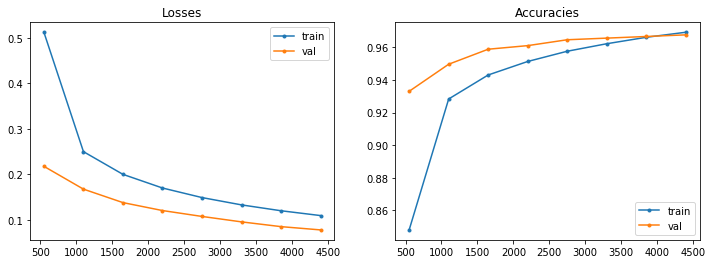

In [18]:
# Construct a custom two-hidden-layer MLP, using any activation function and loss function
mlp_custom = Network()
mlp_custom.add(FCLayer(784, 64))
mlp_custom.add(ReLULayer())
mlp_custom.add(FCLayer(64, 32))
mlp_custom.add(ReLULayer())
mlp_custom.add(FCLayer(32, 10))

criterion_custom = SoftmaxCrossEntropyLossLayer()
sgd = SGD(learning_rate_SGD, weight_decay)

mlp_custom, avg_val_losses, avg_val_accs = train(mlp_custom, criterion_custom, sgd)
print(avg_val_losses, avg_val_accs)

### Further tweaking from best architecture above

In [23]:
def run_exp():
    # Construct a custom two-hidden-layer MLP, using any activation function and loss function
    mlp_custom = Network()
    mlp_custom.add(FCLayer(784, 64))
    mlp_custom.add(ReLULayer())
    mlp_custom.add(FCLayer(64, 32))
    mlp_custom.add(ReLULayer())
    mlp_custom.add(FCLayer(32, 10))

    criterion_custom = SoftmaxCrossEntropyLossLayer()
    sgd = SGD(learning_rate_SGD, weight_decay)

    mlp_custom, avg_val_losses, avg_val_accs = train(mlp_custom, criterion_custom, sgd)
    print(avg_val_losses, avg_val_accs)

In [34]:
max_epoch = 128

Ep[0] loss:0.544 acc:0.800: 100%|████████████████████████████████████████████████████████████████████████████████████████| 550/550 [00:02<00:00, 223.40it/s]
C:\Users\thisi\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in log
Ep[1] loss:0.327 acc:0.920:   4%|███▌                                                                                     | 22/550 [00:00<00:02, 213.59it/s]

Epoch 0 Val loss:0.2479 acc:0.9364


Ep[2] loss:0.221 acc:0.950:   4%|███▋                                                                                     | 23/550 [00:00<00:02, 223.30it/s]

Epoch 1 Val loss:0.1934 acc:0.9510


Ep[3] loss:0.080 acc:0.980:   4%|███▏                                                                                     | 20/550 [00:00<00:02, 192.31it/s]

Epoch 2 Val loss:0.1575 acc:0.9588


Ep[4] loss:0.071 acc:0.980:   4%|███▋                                                                                     | 23/550 [00:00<00:02, 223.30it/s]

Epoch 3 Val loss:0.1368 acc:0.9624


Ep[5] loss:0.059 acc:0.980:   4%|███▌                                                                                     | 22/550 [00:00<00:02, 220.00it/s]

Epoch 4 Val loss:0.1233 acc:0.9648


Ep[6] loss:0.081 acc:0.990:   4%|███▍                                                                                     | 21/550 [00:00<00:02, 207.92it/s]

Epoch 5 Val loss:0.1137 acc:0.9656


Ep[7] loss:0.095 acc:0.970:   4%|███▋                                                                                     | 23/550 [00:00<00:02, 230.00it/s]

Epoch 6 Val loss:0.1074 acc:0.9666


Ep[8] loss:0.047 acc:0.980:   4%|███▋                                                                                     | 23/550 [00:00<00:02, 223.29it/s]

Epoch 7 Val loss:0.1002 acc:0.9672


Ep[9] loss:0.057 acc:0.980:   4%|███▌                                                                                     | 22/550 [00:00<00:02, 215.68it/s]

Epoch 8 Val loss:0.0937 acc:0.9680


Ep[10] loss:0.133 acc:0.930:   4%|███▎                                                                                    | 21/550 [00:00<00:02, 203.87it/s]

Epoch 9 Val loss:0.0864 acc:0.9698


Ep[11] loss:0.066 acc:0.970:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 198.02it/s]

Epoch 10 Val loss:0.0812 acc:0.9704


Ep[12] loss:0.080 acc:0.980:   3%|██▉                                                                                     | 18/550 [00:00<00:03, 174.76it/s]

Epoch 11 Val loss:0.0748 acc:0.9716


Ep[13] loss:0.040 acc:0.990:   3%|██▋                                                                                     | 17/550 [00:00<00:03, 168.32it/s]

Epoch 12 Val loss:0.0690 acc:0.9726


Ep[14] loss:0.020 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 199.99it/s]

Epoch 13 Val loss:0.0641 acc:0.9728


Ep[15] loss:0.083 acc:0.970:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 198.02it/s]

Epoch 14 Val loss:0.0585 acc:0.9732


Ep[16] loss:0.033 acc:0.980:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 196.08it/s]

Epoch 15 Val loss:0.0550 acc:0.9730


Ep[17] loss:0.031 acc:0.980:   4%|███▎                                                                                    | 21/550 [00:00<00:02, 205.88it/s]

Epoch 16 Val loss:0.0508 acc:0.9726


Ep[18] loss:0.029 acc:0.980:   4%|███▎                                                                                    | 21/550 [00:00<00:02, 201.93it/s]

Epoch 17 Val loss:0.0477 acc:0.9736


Ep[19] loss:0.065 acc:0.980:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 200.00it/s]

Epoch 18 Val loss:0.0439 acc:0.9738


Ep[20] loss:0.025 acc:0.990:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 192.30it/s]

Epoch 19 Val loss:0.0409 acc:0.9736


Ep[21] loss:0.024 acc:0.990:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 196.08it/s]

Epoch 20 Val loss:0.0387 acc:0.9732


Ep[22] loss:0.064 acc:0.990:   3%|███                                                                                     | 19/550 [00:00<00:03, 154.47it/s]

Epoch 21 Val loss:0.0374 acc:0.9736


Ep[23] loss:0.016 acc:1.000:   4%|███▎                                                                                    | 21/550 [00:00<00:02, 203.87it/s]

Epoch 22 Val loss:0.0359 acc:0.9736


Ep[24] loss:0.010 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 194.17it/s]

Epoch 23 Val loss:0.0343 acc:0.9736


Ep[25] loss:0.021 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 198.01it/s]

Epoch 24 Val loss:0.0332 acc:0.9736


Ep[26] loss:0.025 acc:0.990:   4%|███▌                                                                                    | 22/550 [00:00<00:02, 213.60it/s]

Epoch 25 Val loss:0.0323 acc:0.9738


Ep[27] loss:0.009 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 184.46it/s]

Epoch 26 Val loss:0.0310 acc:0.9738


Ep[28] loss:0.037 acc:0.990:   4%|███▎                                                                                    | 21/550 [00:00<00:02, 210.00it/s]

Epoch 27 Val loss:0.0299 acc:0.9738


Ep[29] loss:0.014 acc:1.000:   4%|███▎                                                                                    | 21/550 [00:00<00:02, 205.88it/s]

Epoch 28 Val loss:0.0285 acc:0.9742


Ep[30] loss:0.014 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 188.12it/s]

Epoch 29 Val loss:0.0269 acc:0.9744


Ep[31] loss:0.031 acc:0.990:   4%|███▎                                                                                    | 21/550 [00:00<00:02, 205.88it/s]

Epoch 30 Val loss:0.0246 acc:0.9744


Ep[32] loss:0.014 acc:1.000:   4%|███▎                                                                                    | 21/550 [00:00<00:02, 201.92it/s]

Epoch 31 Val loss:0.0232 acc:0.9748


Ep[33] loss:0.013 acc:1.000:   4%|███▎                                                                                    | 21/550 [00:00<00:02, 200.00it/s]

Epoch 32 Val loss:0.0223 acc:0.9744


Ep[34] loss:0.027 acc:0.990:   3%|██▏                                                                                     | 14/550 [00:00<00:03, 137.25it/s]

Epoch 33 Val loss:0.0211 acc:0.9748


Ep[35] loss:0.014 acc:1.000:   4%|███▎                                                                                    | 21/550 [00:00<00:02, 200.00it/s]

Epoch 34 Val loss:0.0210 acc:0.9744


Ep[36] loss:0.007 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 182.69it/s]

Epoch 35 Val loss:0.0204 acc:0.9748


Ep[37] loss:0.013 acc:0.990:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 194.18it/s]

Epoch 36 Val loss:0.0200 acc:0.9748


Ep[38] loss:0.010 acc:1.000:   4%|███▎                                                                                    | 21/550 [00:00<00:02, 209.97it/s]

Epoch 37 Val loss:0.0197 acc:0.9750


Ep[39] loss:0.012 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 194.17it/s]

Epoch 38 Val loss:0.0198 acc:0.9750


Ep[40] loss:0.011 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 198.01it/s]

Epoch 39 Val loss:0.0202 acc:0.9748


Ep[41] loss:0.018 acc:1.000:   4%|███▎                                                                                    | 21/550 [00:00<00:02, 205.87it/s]

Epoch 40 Val loss:0.0197 acc:0.9750


Ep[42] loss:0.006 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 190.00it/s]

Epoch 41 Val loss:0.0202 acc:0.9754


Ep[43] loss:0.016 acc:1.000:   4%|███▌                                                                                    | 22/550 [00:00<00:02, 207.54it/s]

Epoch 42 Val loss:0.0206 acc:0.9756


Ep[44] loss:0.006 acc:1.000:   4%|███▋                                                                                    | 23/550 [00:00<00:02, 227.72it/s]

Epoch 43 Val loss:0.0209 acc:0.9756


Ep[45] loss:0.015 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 196.08it/s]

Epoch 44 Val loss:0.0213 acc:0.9756


Ep[46] loss:0.005 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 190.48it/s]

Epoch 45 Val loss:0.0216 acc:0.9756


Ep[47] loss:0.007 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 196.08it/s]

Epoch 46 Val loss:0.0222 acc:0.9754


Ep[48] loss:0.013 acc:1.000:   4%|███▎                                                                                    | 21/550 [00:00<00:02, 205.88it/s]

Epoch 47 Val loss:0.0230 acc:0.9754


Ep[49] loss:0.008 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 190.48it/s]

Epoch 48 Val loss:0.0238 acc:0.9758


Ep[50] loss:0.005 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 196.08it/s]

Epoch 49 Val loss:0.0245 acc:0.9756


Ep[51] loss:0.005 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 190.47it/s]

Epoch 50 Val loss:0.0245 acc:0.9760


Ep[52] loss:0.005 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 196.08it/s]

Epoch 51 Val loss:0.0269 acc:0.9760


Ep[53] loss:0.006 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 199.99it/s]

Epoch 52 Val loss:0.0266 acc:0.9762


Ep[54] loss:0.004 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 192.30it/s]

Epoch 53 Val loss:0.0274 acc:0.9762


Ep[55] loss:0.005 acc:1.000:   4%|███▎                                                                                    | 21/550 [00:00<00:02, 201.92it/s]

Epoch 54 Val loss:0.0287 acc:0.9764


Ep[56] loss:0.006 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 188.11it/s]

Epoch 55 Val loss:0.0286 acc:0.9762


Ep[57] loss:0.005 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 198.02it/s]

Epoch 56 Val loss:0.0297 acc:0.9766


Ep[58] loss:0.004 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 196.08it/s]

Epoch 57 Val loss:0.0303 acc:0.9762


Ep[59] loss:0.004 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 200.00it/s]

Epoch 58 Val loss:0.0310 acc:0.9764


Ep[60] loss:0.002 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 180.96it/s]

Epoch 59 Val loss:0.0324 acc:0.9762


Ep[61] loss:0.005 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 192.31it/s]

Epoch 60 Val loss:0.0323 acc:0.9762


Ep[62] loss:0.002 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 184.46it/s]

Epoch 61 Val loss:0.0327 acc:0.9762


Ep[63] loss:0.004 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 188.11it/s]

Epoch 62 Val loss:0.0347 acc:0.9762


Ep[64] loss:0.002 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 186.27it/s]

Epoch 63 Val loss:0.0337 acc:0.9762


Ep[65] loss:0.004 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 196.08it/s]

Epoch 64 Val loss:0.0349 acc:0.9760


Ep[66] loss:0.004 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 192.30it/s]

Epoch 65 Val loss:0.0353 acc:0.9760


Ep[67] loss:0.004 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 192.30it/s]

Epoch 66 Val loss:0.0358 acc:0.9760


Ep[68] loss:0.003 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 188.12it/s]

Epoch 67 Val loss:0.0366 acc:0.9760


Ep[69] loss:0.004 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 182.69it/s]

Epoch 68 Val loss:0.0374 acc:0.9760


Ep[70] loss:0.002 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 198.02it/s]

Epoch 69 Val loss:0.0379 acc:0.9760


Ep[71] loss:0.001 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 182.69it/s]

Epoch 70 Val loss:0.0377 acc:0.9760


Ep[72] loss:0.002 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 194.17it/s]

Epoch 71 Val loss:0.0377 acc:0.9760


Ep[73] loss:0.004 acc:1.000:   3%|██▉                                                                                     | 18/550 [00:00<00:03, 176.47it/s]

Epoch 72 Val loss:0.0388 acc:0.9758


Ep[74] loss:0.002 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 194.17it/s]

Epoch 73 Val loss:0.0385 acc:0.9760


Ep[75] loss:0.002 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 190.48it/s]

Epoch 74 Val loss:0.0386 acc:0.9758


Ep[76] loss:0.002 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 189.99it/s]

Epoch 75 Val loss:0.0383 acc:0.9758


Ep[77] loss:0.003 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 182.69it/s]

Epoch 76 Val loss:0.0390 acc:0.9758


Ep[78] loss:0.003 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 196.08it/s]

Epoch 77 Val loss:0.0389 acc:0.9760


Ep[79] loss:0.003 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 186.27it/s]

Epoch 78 Val loss:0.0389 acc:0.9760


Ep[80] loss:0.003 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 186.27it/s]

Epoch 79 Val loss:0.0397 acc:0.9760


Ep[81] loss:0.003 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 184.46it/s]

Epoch 80 Val loss:0.0395 acc:0.9758


Ep[82] loss:0.002 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 192.31it/s]

Epoch 81 Val loss:0.0400 acc:0.9758


Ep[83] loss:0.002 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 184.47it/s]

Epoch 82 Val loss:0.0397 acc:0.9758


Ep[84] loss:0.002 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 198.01it/s]

Epoch 83 Val loss:0.0401 acc:0.9758


Ep[85] loss:0.003 acc:1.000:   4%|███▌                                                                                    | 22/550 [00:00<00:02, 215.69it/s]

Epoch 84 Val loss:0.0403 acc:0.9756


Ep[86] loss:0.002 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 188.12it/s]

Epoch 85 Val loss:0.0405 acc:0.9758


Ep[87] loss:0.002 acc:1.000:   3%|██▉                                                                                     | 18/550 [00:00<00:03, 174.76it/s]

Epoch 86 Val loss:0.0410 acc:0.9754


Ep[88] loss:0.002 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 200.00it/s]

Epoch 87 Val loss:0.0409 acc:0.9754


Ep[89] loss:0.003 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 180.95it/s]

Epoch 88 Val loss:0.0412 acc:0.9754


Ep[90] loss:0.001 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 186.27it/s]

Epoch 89 Val loss:0.0413 acc:0.9750


Ep[91] loss:0.002 acc:1.000:   3%|██▉                                                                                     | 18/550 [00:00<00:02, 178.21it/s]

Epoch 90 Val loss:0.0415 acc:0.9748


Ep[92] loss:0.001 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 188.11it/s]

Epoch 91 Val loss:0.0420 acc:0.9746


Ep[93] loss:0.001 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 180.95it/s]

Epoch 92 Val loss:0.0421 acc:0.9746


Ep[94] loss:0.001 acc:1.000:   3%|██▉                                                                                     | 18/550 [00:00<00:02, 180.00it/s]

Epoch 93 Val loss:0.0420 acc:0.9746


Ep[95] loss:0.001 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 186.27it/s]

Epoch 94 Val loss:0.0429 acc:0.9746


Ep[96] loss:0.003 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 182.69it/s]

Epoch 95 Val loss:0.0425 acc:0.9748


Ep[97] loss:0.002 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 182.69it/s]

Epoch 96 Val loss:0.0429 acc:0.9748


Ep[98] loss:0.002 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 184.46it/s]

Epoch 97 Val loss:0.0435 acc:0.9748


Ep[99] loss:0.001 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 190.48it/s]

Epoch 98 Val loss:0.0433 acc:0.9748


Ep[100] loss:0.002 acc:1.000:   3%|███                                                                                    | 19/550 [00:00<00:02, 184.46it/s]

Epoch 99 Val loss:0.0434 acc:0.9750


Ep[101] loss:0.001 acc:1.000:   3%|███                                                                                    | 19/550 [00:00<00:02, 188.11it/s]

Epoch 100 Val loss:0.0438 acc:0.9748


Ep[102] loss:0.002 acc:1.000:   3%|██▋                                                                                    | 17/550 [00:00<00:03, 170.00it/s]

Epoch 101 Val loss:0.0440 acc:0.9750


Ep[103] loss:0.002 acc:1.000:   3%|███                                                                                    | 19/550 [00:00<00:02, 179.25it/s]

Epoch 102 Val loss:0.0440 acc:0.9748


Ep[104] loss:0.002 acc:1.000:   3%|██▋                                                                                    | 17/550 [00:00<00:03, 163.46it/s]

Epoch 103 Val loss:0.0439 acc:0.9750


Ep[105] loss:0.001 acc:1.000:   3%|██▊                                                                                    | 18/550 [00:00<00:03, 176.46it/s]

Epoch 104 Val loss:0.0446 acc:0.9748


Ep[106] loss:0.001 acc:1.000:   3%|██▊                                                                                    | 18/550 [00:00<00:02, 179.99it/s]

Epoch 105 Val loss:0.0448 acc:0.9750


Ep[107] loss:0.002 acc:1.000:   3%|███                                                                                    | 19/550 [00:00<00:02, 180.96it/s]

Epoch 106 Val loss:0.0446 acc:0.9750


Ep[108] loss:0.002 acc:1.000:   3%|██▊                                                                                    | 18/550 [00:00<00:03, 176.46it/s]

Epoch 107 Val loss:0.0446 acc:0.9748


Ep[109] loss:0.002 acc:1.000:   3%|██▊                                                                                    | 18/550 [00:00<00:02, 178.21it/s]

Epoch 108 Val loss:0.0452 acc:0.9748


Ep[110] loss:0.002 acc:1.000:   3%|██▊                                                                                    | 18/550 [00:00<00:02, 178.22it/s]

Epoch 109 Val loss:0.0451 acc:0.9748


Ep[111] loss:0.001 acc:1.000:   3%|███                                                                                    | 19/550 [00:00<00:02, 182.69it/s]

Epoch 110 Val loss:0.0453 acc:0.9750


Ep[112] loss:0.002 acc:1.000:   3%|██▊                                                                                    | 18/550 [00:00<00:03, 169.82it/s]

Epoch 111 Val loss:0.0457 acc:0.9748


Ep[113] loss:0.001 acc:1.000:   3%|██▊                                                                                    | 18/550 [00:00<00:02, 178.22it/s]

Epoch 112 Val loss:0.0451 acc:0.9746


Ep[114] loss:0.001 acc:1.000:   3%|██▊                                                                                    | 18/550 [00:00<00:03, 173.07it/s]

Epoch 113 Val loss:0.0456 acc:0.9748


Ep[115] loss:0.002 acc:1.000:   3%|██▊                                                                                    | 18/550 [00:00<00:03, 173.08it/s]

Epoch 114 Val loss:0.0460 acc:0.9748


Ep[116] loss:0.001 acc:1.000:   3%|██▊                                                                                    | 18/550 [00:00<00:03, 176.47it/s]

Epoch 115 Val loss:0.0458 acc:0.9746


Ep[117] loss:0.000 acc:1.000:   3%|██▋                                                                                    | 17/550 [00:00<00:03, 168.31it/s]

Epoch 116 Val loss:0.0461 acc:0.9748


Ep[118] loss:0.002 acc:1.000:   3%|██▋                                                                                    | 17/550 [00:00<00:03, 170.00it/s]

Epoch 117 Val loss:0.0462 acc:0.9748


Ep[119] loss:0.001 acc:1.000:   3%|██▊                                                                                    | 18/550 [00:00<00:03, 173.08it/s]

Epoch 118 Val loss:0.0463 acc:0.9746


Ep[120] loss:0.001 acc:1.000:   3%|██▊                                                                                    | 18/550 [00:00<00:03, 174.76it/s]

Epoch 119 Val loss:0.0465 acc:0.9746


Ep[121] loss:0.001 acc:1.000:   3%|██▊                                                                                    | 18/550 [00:00<00:02, 178.22it/s]

Epoch 120 Val loss:0.0466 acc:0.9746


Ep[122] loss:0.001 acc:1.000:   3%|██▋                                                                                    | 17/550 [00:00<00:03, 168.32it/s]

Epoch 121 Val loss:0.0468 acc:0.9746


Ep[123] loss:0.001 acc:1.000:   3%|██▊                                                                                    | 18/550 [00:00<00:03, 169.81it/s]

Epoch 122 Val loss:0.0467 acc:0.9746


Ep[124] loss:0.001 acc:1.000:   3%|███                                                                                    | 19/550 [00:00<00:02, 182.69it/s]

Epoch 123 Val loss:0.0468 acc:0.9746


Ep[125] loss:0.002 acc:1.000:   3%|███                                                                                    | 19/550 [00:00<00:02, 184.47it/s]

Epoch 124 Val loss:0.0468 acc:0.9746


Ep[126] loss:0.001 acc:1.000:   3%|██▊                                                                                    | 18/550 [00:00<00:02, 180.00it/s]

Epoch 125 Val loss:0.0469 acc:0.9746


Ep[127] loss:0.002 acc:1.000:   3%|███                                                                                    | 19/550 [00:00<00:02, 184.47it/s]

Epoch 126 Val loss:0.0471 acc:0.9746


Ep[127] loss:0.002 acc:1.000: 100%|██████████████████████████████████████████████████████████████████████████████████████| 550/550 [00:03<00:00, 171.88it/s]


Epoch 127 Val loss:0.0470 acc:0.9746

Test acc is 0.9765

[0.24789480437784334, 0.19341739344221626, 0.15747126990216306, 0.1368083481878584, 0.12332701532667699, 0.1137080695577015, 0.10740443063326505, 0.10024641212661439, 0.09374810337488582, 0.08642985688042987, 0.08118296746985473, 0.07483678200382399, 0.06902395242111549, 0.064084217581506, 0.05849638304731499, 0.05498684512759508, 0.05077399415655304, 0.0477395177757033, 0.043903652433728395, 0.04091156244743784, 0.03866728694607379, 0.03739216008946095, 0.03589018400887602, 0.03428595572793015, 0.03319469851339126, 0.032292164860152364, 0.031040348322778705, 0.029892223407423448, 0.028525524085126635, 0.02690001899595285, 0.024568734836511653, 0.023200568334181066, 0.022281337829043978, 0.021096865431132275, 0.020961722858525864, 0.020404723364173528, 0.019970780689273035, 0.01968446387090695, 0.019804864417653233, 0.0201714826550506, 0.01971588474327546, 0.020209020494921476, 0.020559374445112914, 0.02093802490645674, 0.021271

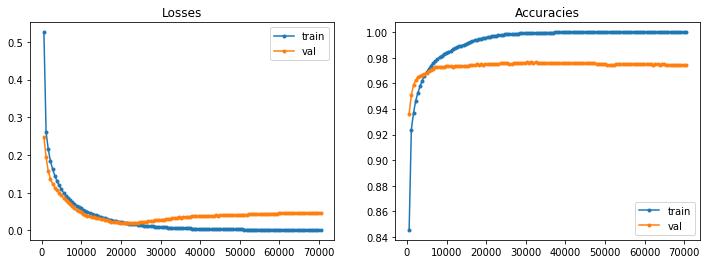

In [35]:
run_exp()

Ep[0] loss:0.534 acc:0.840: 100%|████████████████████████████████████████████████████████████████████████████████████████| 550/550 [00:02<00:00, 196.22it/s]
C:\Users\thisi\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in log
Ep[1] loss:0.175 acc:0.960:   4%|███▌                                                                                     | 22/550 [00:00<00:02, 213.58it/s]

Epoch 0 Val loss:0.2321 acc:0.9370


Ep[2] loss:0.228 acc:0.940:   3%|███                                                                                      | 19/550 [00:00<00:02, 188.11it/s]

Epoch 1 Val loss:0.1538 acc:0.9504


Ep[3] loss:0.138 acc:0.940:   3%|██▊                                                                                      | 17/550 [00:00<00:03, 161.89it/s]

Epoch 2 Val loss:0.1132 acc:0.9554


Ep[4] loss:0.086 acc:0.970:   4%|███▋                                                                                     | 23/550 [00:00<00:02, 225.49it/s]

Epoch 3 Val loss:0.0950 acc:0.9614


Ep[5] loss:0.060 acc:0.970:   4%|███▉                                                                                     | 24/550 [00:00<00:02, 235.29it/s]

Epoch 4 Val loss:0.0850 acc:0.9636


Ep[6] loss:0.058 acc:0.970:   4%|███▋                                                                                     | 23/550 [00:00<00:02, 223.30it/s]

Epoch 5 Val loss:0.0802 acc:0.9636


Ep[7] loss:0.061 acc:0.980:   4%|███▌                                                                                     | 22/550 [00:00<00:02, 219.99it/s]

Epoch 6 Val loss:0.0766 acc:0.9644


Ep[8] loss:0.058 acc:0.970:   4%|███▋                                                                                     | 23/550 [00:00<00:02, 223.27it/s]

Epoch 7 Val loss:0.0751 acc:0.9654


Ep[9] loss:0.116 acc:0.960:   4%|███▋                                                                                     | 23/550 [00:00<00:02, 227.71it/s]

Epoch 8 Val loss:0.0750 acc:0.9666


Ep[10] loss:0.063 acc:0.990:   3%|██▉                                                                                     | 18/550 [00:00<00:03, 169.81it/s]

Epoch 9 Val loss:0.0756 acc:0.9676


Ep[11] loss:0.051 acc:0.980:   4%|███▌                                                                                    | 22/550 [00:00<00:02, 217.83it/s]

Epoch 10 Val loss:0.0744 acc:0.9686


Ep[12] loss:0.086 acc:0.980:   4%|███▎                                                                                    | 21/550 [00:00<00:02, 203.89it/s]

Epoch 11 Val loss:0.0744 acc:0.9682


Ep[13] loss:0.033 acc:0.990:   3%|███                                                                                     | 19/550 [00:00<00:02, 184.46it/s]

Epoch 12 Val loss:0.0746 acc:0.9700


Ep[14] loss:0.079 acc:0.960:   4%|███▋                                                                                    | 23/550 [00:00<00:02, 223.30it/s]

Epoch 13 Val loss:0.0768 acc:0.9702


Ep[15] loss:0.047 acc:0.980:   4%|███▎                                                                                    | 21/550 [00:00<00:02, 205.89it/s]

Epoch 14 Val loss:0.0767 acc:0.9710


Ep[16] loss:0.048 acc:0.990:   3%|███                                                                                     | 19/550 [00:00<00:02, 190.00it/s]

Epoch 15 Val loss:0.0778 acc:0.9708


Ep[17] loss:0.043 acc:0.980:   4%|███▎                                                                                    | 21/550 [00:00<00:02, 205.88it/s]

Epoch 16 Val loss:0.0775 acc:0.9712


Ep[18] loss:0.059 acc:0.980:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 192.30it/s]

Epoch 17 Val loss:0.0785 acc:0.9716


Ep[19] loss:0.055 acc:0.980:   4%|███▌                                                                                    | 22/550 [00:00<00:02, 211.53it/s]

Epoch 18 Val loss:0.0780 acc:0.9716


Ep[20] loss:0.054 acc:0.980:   4%|███▎                                                                                    | 21/550 [00:00<00:02, 201.92it/s]

Epoch 19 Val loss:0.0781 acc:0.9714


Ep[21] loss:0.040 acc:0.980:   4%|███▌                                                                                    | 22/550 [00:00<00:02, 209.53it/s]

Epoch 20 Val loss:0.0786 acc:0.9716


Ep[22] loss:0.017 acc:1.000:   4%|███▎                                                                                    | 21/550 [00:00<00:02, 210.00it/s]

Epoch 21 Val loss:0.0779 acc:0.9716


Ep[23] loss:0.045 acc:0.980:   4%|███▎                                                                                    | 21/550 [00:00<00:02, 201.92it/s]

Epoch 22 Val loss:0.0770 acc:0.9726


Ep[24] loss:0.041 acc:0.980:   4%|███▌                                                                                    | 22/550 [00:00<00:02, 215.68it/s]

Epoch 23 Val loss:0.0750 acc:0.9730


Ep[25] loss:0.033 acc:0.980:   4%|███▌                                                                                    | 22/550 [00:00<00:02, 211.53it/s]

Epoch 24 Val loss:0.0743 acc:0.9736


Ep[26] loss:0.026 acc:1.000:   3%|██▉                                                                                     | 18/550 [00:00<00:03, 173.07it/s]

Epoch 25 Val loss:0.0731 acc:0.9740


Ep[27] loss:0.016 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 198.01it/s]

Epoch 26 Val loss:0.0710 acc:0.9742


Ep[28] loss:0.025 acc:0.980:   4%|███▎                                                                                    | 21/550 [00:00<00:02, 205.88it/s]

Epoch 27 Val loss:0.0703 acc:0.9738


Ep[29] loss:0.010 acc:1.000:   4%|███▎                                                                                    | 21/550 [00:00<00:02, 205.88it/s]

Epoch 28 Val loss:0.0694 acc:0.9734


Ep[30] loss:0.015 acc:1.000:   4%|███▌                                                                                    | 22/550 [00:00<00:02, 213.59it/s]

Epoch 29 Val loss:0.0689 acc:0.9732


Ep[31] loss:0.014 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 192.31it/s]

Epoch 30 Val loss:0.0716 acc:0.9738


Ep[32] loss:0.027 acc:0.990:   4%|███▌                                                                                    | 22/550 [00:00<00:02, 213.59it/s]

Epoch 31 Val loss:0.0691 acc:0.9740


Ep[33] loss:0.013 acc:1.000:   4%|███▎                                                                                    | 21/550 [00:00<00:02, 203.89it/s]

Epoch 32 Val loss:0.0677 acc:0.9734


Ep[34] loss:0.024 acc:0.990:   4%|███▎                                                                                    | 21/550 [00:00<00:02, 205.88it/s]

Epoch 33 Val loss:0.0682 acc:0.9736


Ep[35] loss:0.022 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 196.08it/s]

Epoch 34 Val loss:0.0655 acc:0.9736


Ep[36] loss:0.011 acc:1.000:   4%|███▎                                                                                    | 21/550 [00:00<00:02, 200.00it/s]

Epoch 35 Val loss:0.0648 acc:0.9732


Ep[37] loss:0.020 acc:1.000:   4%|███▌                                                                                    | 22/550 [00:00<00:02, 211.55it/s]

Epoch 36 Val loss:0.0650 acc:0.9732


Ep[38] loss:0.007 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 198.02it/s]

Epoch 37 Val loss:0.0628 acc:0.9734


Ep[39] loss:0.011 acc:1.000:   3%|██▉                                                                                     | 18/550 [00:00<00:03, 173.08it/s]

Epoch 38 Val loss:0.0652 acc:0.9730


Ep[40] loss:0.007 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 190.00it/s]

Epoch 39 Val loss:0.0617 acc:0.9732


Ep[41] loss:0.009 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 198.03it/s]

Epoch 40 Val loss:0.0629 acc:0.9730


Ep[42] loss:0.013 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 196.07it/s]

Epoch 41 Val loss:0.0624 acc:0.9728


Ep[43] loss:0.008 acc:1.000:   4%|███▊                                                                                    | 24/550 [00:00<00:02, 233.00it/s]

Epoch 42 Val loss:0.0633 acc:0.9728


Ep[44] loss:0.011 acc:1.000:   4%|███▎                                                                                    | 21/550 [00:00<00:02, 201.92it/s]

Epoch 43 Val loss:0.0628 acc:0.9730


Ep[45] loss:0.007 acc:1.000:   5%|████▏                                                                                   | 26/550 [00:00<00:02, 250.00it/s]

Epoch 44 Val loss:0.0609 acc:0.9732


Ep[46] loss:0.007 acc:1.000:   5%|████                                                                                    | 25/550 [00:00<00:02, 245.09it/s]

Epoch 45 Val loss:0.0614 acc:0.9732


Ep[47] loss:0.006 acc:1.000:   4%|███▋                                                                                    | 23/550 [00:00<00:02, 227.71it/s]

Epoch 46 Val loss:0.0604 acc:0.9730


Ep[48] loss:0.006 acc:1.000:   4%|███▋                                                                                    | 23/550 [00:00<00:02, 227.72it/s]

Epoch 47 Val loss:0.0608 acc:0.9734


Ep[49] loss:0.008 acc:1.000:   4%|███▋                                                                                    | 23/550 [00:00<00:02, 223.30it/s]

Epoch 48 Val loss:0.0609 acc:0.9730


Ep[50] loss:0.006 acc:1.000:   4%|███▊                                                                                    | 24/550 [00:00<00:02, 235.29it/s]

Epoch 49 Val loss:0.0627 acc:0.9738


Ep[51] loss:0.018 acc:0.990:   5%|████                                                                                    | 25/550 [00:00<00:02, 242.72it/s]

Epoch 50 Val loss:0.0632 acc:0.9738


Ep[52] loss:0.004 acc:1.000:   4%|███▌                                                                                    | 22/550 [00:00<00:02, 217.82it/s]

Epoch 51 Val loss:0.0642 acc:0.9738


Ep[53] loss:0.006 acc:1.000:   4%|███▋                                                                                    | 23/550 [00:00<00:02, 223.29it/s]

Epoch 52 Val loss:0.0634 acc:0.9736


Ep[54] loss:0.003 acc:1.000:   4%|███▊                                                                                    | 24/550 [00:00<00:02, 235.29it/s]

Epoch 53 Val loss:0.0641 acc:0.9740


Ep[55] loss:0.005 acc:1.000:   4%|███▋                                                                                    | 23/550 [00:00<00:02, 227.73it/s]

Epoch 54 Val loss:0.0644 acc:0.9738


Ep[56] loss:0.005 acc:1.000:   4%|███▊                                                                                    | 24/550 [00:00<00:02, 230.76it/s]

Epoch 55 Val loss:0.0658 acc:0.9740


Ep[57] loss:0.008 acc:1.000:   4%|███▎                                                                                    | 21/550 [00:00<00:02, 207.92it/s]

Epoch 56 Val loss:0.0660 acc:0.9736


Ep[58] loss:0.004 acc:1.000:   4%|███▊                                                                                    | 24/550 [00:00<00:02, 235.28it/s]

Epoch 57 Val loss:0.0658 acc:0.9738


Ep[59] loss:0.004 acc:1.000:   4%|███▊                                                                                    | 24/550 [00:00<00:02, 237.63it/s]

Epoch 58 Val loss:0.0669 acc:0.9736


Ep[60] loss:0.005 acc:1.000:   4%|███▊                                                                                    | 24/550 [00:00<00:02, 235.29it/s]

Epoch 59 Val loss:0.0661 acc:0.9738


Ep[61] loss:0.006 acc:1.000:   4%|███▋                                                                                    | 23/550 [00:00<00:02, 223.30it/s]

Epoch 60 Val loss:0.0674 acc:0.9736


Ep[62] loss:0.007 acc:1.000:   4%|███▎                                                                                    | 21/550 [00:00<00:02, 209.99it/s]

Epoch 61 Val loss:0.0685 acc:0.9732


Ep[63] loss:0.002 acc:1.000:   4%|███▊                                                                                    | 24/550 [00:00<00:02, 235.30it/s]

Epoch 62 Val loss:0.0686 acc:0.9736


Ep[64] loss:0.001 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 188.12it/s]

Epoch 63 Val loss:0.0699 acc:0.9732


Ep[65] loss:0.002 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 194.17it/s]

Epoch 64 Val loss:0.0709 acc:0.9730


Ep[66] loss:0.001 acc:1.000:   3%|██▉                                                                                     | 18/550 [00:00<00:03, 174.76it/s]

Epoch 65 Val loss:0.0729 acc:0.9728


Ep[67] loss:0.004 acc:1.000:   4%|███▎                                                                                    | 21/550 [00:00<00:02, 205.88it/s]

Epoch 66 Val loss:0.0726 acc:0.9730


Ep[68] loss:0.001 acc:1.000:   4%|███▌                                                                                    | 22/550 [00:00<00:02, 213.59it/s]

Epoch 67 Val loss:0.0751 acc:0.9730


Ep[69] loss:0.003 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 200.00it/s]

Epoch 68 Val loss:0.0745 acc:0.9730


Ep[70] loss:0.004 acc:1.000:   4%|███▎                                                                                    | 21/550 [00:00<00:02, 207.92it/s]

Epoch 69 Val loss:0.0756 acc:0.9728


Ep[71] loss:0.002 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 198.01it/s]

Epoch 70 Val loss:0.0759 acc:0.9726


Ep[72] loss:0.005 acc:1.000:   4%|███▎                                                                                    | 21/550 [00:00<00:02, 201.92it/s]

Epoch 71 Val loss:0.0772 acc:0.9726


Ep[73] loss:0.004 acc:1.000:   3%|██▋                                                                                     | 17/550 [00:00<00:03, 163.45it/s]

Epoch 72 Val loss:0.0785 acc:0.9726


Ep[74] loss:0.004 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 180.95it/s]

Epoch 73 Val loss:0.0788 acc:0.9724


Ep[75] loss:0.003 acc:1.000:   3%|██▉                                                                                     | 18/550 [00:00<00:02, 178.22it/s]

Epoch 74 Val loss:0.0789 acc:0.9728


Ep[76] loss:0.002 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 196.08it/s]

Epoch 75 Val loss:0.0793 acc:0.9726


Ep[77] loss:0.001 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 186.27it/s]

Epoch 76 Val loss:0.0804 acc:0.9728


Ep[78] loss:0.003 acc:1.000:   4%|███▎                                                                                    | 21/550 [00:00<00:02, 201.91it/s]

Epoch 77 Val loss:0.0806 acc:0.9724


Ep[79] loss:0.003 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 190.48it/s]

Epoch 78 Val loss:0.0815 acc:0.9724


Ep[80] loss:0.001 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 192.31it/s]

Epoch 79 Val loss:0.0816 acc:0.9722


Ep[81] loss:0.003 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 190.00it/s]

Epoch 80 Val loss:0.0821 acc:0.9724


Ep[82] loss:0.003 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 184.47it/s]

Epoch 81 Val loss:0.0824 acc:0.9726


Ep[83] loss:0.003 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 184.46it/s]

Epoch 82 Val loss:0.0825 acc:0.9728


Ep[84] loss:0.001 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 188.12it/s]

Epoch 83 Val loss:0.0834 acc:0.9732


Ep[85] loss:0.001 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 184.47it/s]

Epoch 84 Val loss:0.0837 acc:0.9732


Ep[86] loss:0.003 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 192.31it/s]

Epoch 85 Val loss:0.0838 acc:0.9734


Ep[87] loss:0.003 acc:1.000:   3%|██▉                                                                                     | 18/550 [00:00<00:03, 174.76it/s]

Epoch 86 Val loss:0.0845 acc:0.9736


Ep[88] loss:0.002 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 200.00it/s]

Epoch 87 Val loss:0.0846 acc:0.9734


Ep[89] loss:0.002 acc:1.000:   3%|██▋                                                                                     | 17/550 [00:00<00:03, 165.05it/s]

Epoch 88 Val loss:0.0840 acc:0.9734


Ep[90] loss:0.001 acc:1.000:   2%|█▉                                                                                      | 12/550 [00:00<00:04, 119.99it/s]

Epoch 89 Val loss:0.0855 acc:0.9736


Ep[91] loss:0.003 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 186.27it/s]

Epoch 90 Val loss:0.0851 acc:0.9738


Ep[92] loss:0.002 acc:1.000:   3%|██▉                                                                                     | 18/550 [00:00<00:03, 173.08it/s]

Epoch 91 Val loss:0.0851 acc:0.9738


Ep[93] loss:0.003 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 190.47it/s]

Epoch 92 Val loss:0.0861 acc:0.9738


Ep[94] loss:0.002 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 179.25it/s]

Epoch 93 Val loss:0.0863 acc:0.9738


Ep[95] loss:0.001 acc:1.000:   3%|██▉                                                                                     | 18/550 [00:00<00:02, 178.23it/s]

Epoch 94 Val loss:0.0864 acc:0.9738


Ep[96] loss:0.002 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 180.93it/s]

Epoch 95 Val loss:0.0866 acc:0.9736


Ep[97] loss:0.001 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 188.12it/s]

Epoch 96 Val loss:0.0869 acc:0.9736


Ep[98] loss:0.002 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 179.25it/s]

Epoch 97 Val loss:0.0869 acc:0.9736


Ep[99] loss:0.002 acc:1.000:   3%|██▉                                                                                     | 18/550 [00:00<00:03, 174.75it/s]

Epoch 98 Val loss:0.0871 acc:0.9736


Ep[100] loss:0.001 acc:1.000:   4%|███▏                                                                                   | 20/550 [00:00<00:02, 198.02it/s]

Epoch 99 Val loss:0.0875 acc:0.9736


Ep[101] loss:0.002 acc:1.000:   3%|██▋                                                                                    | 17/550 [00:00<00:03, 161.90it/s]

Epoch 100 Val loss:0.0880 acc:0.9736


Ep[102] loss:0.001 acc:1.000:   4%|███▏                                                                                   | 20/550 [00:00<00:02, 200.00it/s]

Epoch 101 Val loss:0.0883 acc:0.9736


Ep[103] loss:0.001 acc:1.000:   3%|███                                                                                    | 19/550 [00:00<00:02, 180.96it/s]

Epoch 102 Val loss:0.0890 acc:0.9736


Ep[104] loss:0.000 acc:1.000:   3%|██▊                                                                                    | 18/550 [00:00<00:02, 180.00it/s]

Epoch 103 Val loss:0.0892 acc:0.9736


Ep[105] loss:0.000 acc:1.000:   3%|██▊                                                                                    | 18/550 [00:00<00:03, 176.47it/s]

Epoch 104 Val loss:0.0892 acc:0.9736


Ep[106] loss:0.002 acc:1.000:   4%|███▏                                                                                   | 20/550 [00:00<00:02, 192.30it/s]

Epoch 105 Val loss:0.0892 acc:0.9734


Ep[107] loss:0.000 acc:1.000:   3%|██▊                                                                                    | 18/550 [00:00<00:02, 180.00it/s]

Epoch 106 Val loss:0.0897 acc:0.9734


Ep[108] loss:0.000 acc:1.000:   4%|███▏                                                                                   | 20/550 [00:00<00:02, 190.47it/s]

Epoch 107 Val loss:0.0904 acc:0.9736


Ep[109] loss:0.001 acc:1.000:   3%|██▊                                                                                    | 18/550 [00:00<00:02, 178.21it/s]

Epoch 108 Val loss:0.0901 acc:0.9736


Ep[110] loss:0.002 acc:1.000:   3%|██▋                                                                                    | 17/550 [00:00<00:03, 165.05it/s]

Epoch 109 Val loss:0.0904 acc:0.9736


Ep[111] loss:0.001 acc:1.000:   3%|███                                                                                    | 19/550 [00:00<00:02, 180.95it/s]

Epoch 110 Val loss:0.0908 acc:0.9738


Ep[112] loss:0.000 acc:1.000:   3%|██▋                                                                                    | 17/550 [00:00<00:03, 168.32it/s]

Epoch 111 Val loss:0.0914 acc:0.9738


Ep[113] loss:0.000 acc:1.000:   3%|██▊                                                                                    | 18/550 [00:00<00:03, 169.81it/s]

Epoch 112 Val loss:0.0913 acc:0.9738


Ep[114] loss:0.000 acc:1.000:   3%|███                                                                                    | 19/550 [00:00<00:02, 186.27it/s]

Epoch 113 Val loss:0.0918 acc:0.9738


Ep[115] loss:0.001 acc:1.000:   3%|██▌                                                                                    | 16/550 [00:00<00:03, 158.41it/s]

Epoch 114 Val loss:0.0915 acc:0.9738


Ep[116] loss:0.000 acc:1.000:   3%|███                                                                                    | 19/550 [00:00<00:02, 180.95it/s]

Epoch 115 Val loss:0.0918 acc:0.9738


Ep[117] loss:0.001 acc:1.000:   3%|██▊                                                                                    | 18/550 [00:00<00:03, 171.43it/s]

Epoch 116 Val loss:0.0922 acc:0.9740


Ep[118] loss:0.002 acc:1.000:   3%|██▊                                                                                    | 18/550 [00:00<00:03, 174.75it/s]

Epoch 117 Val loss:0.0922 acc:0.9738


Ep[119] loss:0.001 acc:1.000:   3%|██▊                                                                                    | 18/550 [00:00<00:02, 180.00it/s]

Epoch 118 Val loss:0.0925 acc:0.9738


Ep[120] loss:0.002 acc:1.000:   3%|███                                                                                    | 19/550 [00:00<00:02, 179.24it/s]

Epoch 119 Val loss:0.0928 acc:0.9742


Ep[121] loss:0.001 acc:1.000:   3%|██▌                                                                                    | 16/550 [00:00<00:03, 156.86it/s]

Epoch 120 Val loss:0.0926 acc:0.9742


Ep[122] loss:0.001 acc:1.000:   3%|██▊                                                                                    | 18/550 [00:00<00:03, 171.43it/s]

Epoch 121 Val loss:0.0926 acc:0.9742


Ep[123] loss:0.000 acc:1.000:   3%|███                                                                                    | 19/550 [00:00<00:02, 184.46it/s]

Epoch 122 Val loss:0.0932 acc:0.9744


Ep[124] loss:0.001 acc:1.000:   3%|███                                                                                    | 19/550 [00:00<00:02, 180.95it/s]

Epoch 123 Val loss:0.0929 acc:0.9744


Ep[125] loss:0.001 acc:1.000:   3%|██▊                                                                                    | 18/550 [00:00<00:03, 176.47it/s]

Epoch 124 Val loss:0.0933 acc:0.9742


Ep[126] loss:0.001 acc:1.000:   3%|██▋                                                                                    | 17/550 [00:00<00:03, 163.46it/s]

Epoch 125 Val loss:0.0935 acc:0.9744


Ep[127] loss:0.000 acc:1.000:   3%|██▋                                                                                    | 17/550 [00:00<00:03, 166.66it/s]

Epoch 126 Val loss:0.0935 acc:0.9744


Ep[127] loss:0.002 acc:1.000: 100%|██████████████████████████████████████████████████████████████████████████████████████| 550/550 [00:03<00:00, 171.82it/s]


Epoch 127 Val loss:0.0931 acc:0.9744

Test acc is 0.9726

[0.23210809588458556, 0.15377658833417282, 0.11320417657917689, 0.09496242865608451, 0.0850496347958595, 0.08019156397809785, 0.07664101756376147, 0.07508021742739912, 0.07496063083928356, 0.07557820345967987, 0.07442460929706049, 0.0744054555009611, 0.07461090499852045, 0.07678268357871558, 0.07665045952453395, 0.07784173799833032, 0.0774844252373114, 0.07845138458487329, 0.07798698973200077, 0.07813371347191553, 0.07862589755242226, 0.07785102014870568, 0.07702146272676212, 0.0750008515028153, 0.07433518586966917, 0.0730927731799301, 0.0710454271169964, 0.07034964774514983, 0.069396549450796, 0.06888657576719233, 0.07157164986768792, 0.06905564576951188, 0.06765707517703326, 0.0681518535444639, 0.0654776365906735, 0.06482671665040747, 0.06503906073272496, 0.06283580892541779, 0.06516495210903607, 0.061714925563905176, 0.06285455078977727, 0.0623984480900579, 0.06328643269445143, 0.06276815962403334, 0.060850078877994124, 0.061

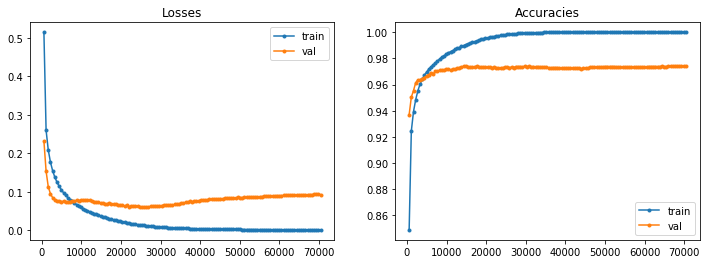

In [36]:
weight_decay = 0.002
run_exp()

Ep[0] loss:0.447 acc:0.820: 100%|████████████████████████████████████████████████████████████████████████████████████████| 550/550 [00:02<00:00, 219.47it/s]
C:\Users\thisi\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in log
Ep[1] loss:0.382 acc:0.880:   4%|███▉                                                                                     | 24/550 [00:00<00:02, 230.76it/s]

Epoch 0 Val loss:0.1919 acc:0.9308


Ep[2] loss:0.094 acc:0.980:   4%|███▋                                                                                     | 23/550 [00:00<00:02, 225.49it/s]

Epoch 1 Val loss:0.1512 acc:0.9466


Ep[3] loss:0.157 acc:0.950:   4%|███▋                                                                                     | 23/550 [00:00<00:02, 227.72it/s]

Epoch 2 Val loss:0.1364 acc:0.9546


Ep[4] loss:0.199 acc:0.930:   4%|███▉                                                                                     | 24/550 [00:00<00:02, 228.57it/s]

Epoch 3 Val loss:0.1260 acc:0.9568


Ep[5] loss:0.157 acc:0.960:   3%|██▉                                                                                      | 18/550 [00:00<00:03, 171.44it/s]

Epoch 4 Val loss:0.1224 acc:0.9616


Ep[6] loss:0.139 acc:0.960:   3%|██▊                                                                                      | 17/550 [00:00<00:03, 168.32it/s]

Epoch 5 Val loss:0.1205 acc:0.9648


Ep[7] loss:0.037 acc:1.000:   4%|███▏                                                                                     | 20/550 [00:00<00:02, 200.00it/s]

Epoch 6 Val loss:0.1165 acc:0.9664


Ep[8] loss:0.030 acc:1.000:   4%|███▏                                                                                     | 20/550 [00:00<00:02, 194.17it/s]

Epoch 7 Val loss:0.1117 acc:0.9686


Ep[9] loss:0.026 acc:1.000:   3%|███                                                                                      | 19/550 [00:00<00:02, 188.11it/s]

Epoch 8 Val loss:0.1090 acc:0.9682


Ep[10] loss:0.019 acc:1.000:   3%|██▉                                                                                     | 18/550 [00:00<00:03, 176.48it/s]

Epoch 9 Val loss:0.1063 acc:0.9684


Ep[11] loss:0.017 acc:1.000:   3%|██▋                                                                                     | 17/550 [00:00<00:03, 169.99it/s]

Epoch 10 Val loss:0.1034 acc:0.9686


Ep[12] loss:0.073 acc:0.990:   3%|██▉                                                                                     | 18/550 [00:00<00:03, 176.47it/s]

Epoch 11 Val loss:0.1018 acc:0.9686


Ep[13] loss:0.056 acc:0.990:   3%|██▌                                                                                     | 16/550 [00:00<00:03, 155.33it/s]

Epoch 12 Val loss:0.0996 acc:0.9692


Ep[14] loss:0.053 acc:1.000:   3%|██▋                                                                                     | 17/550 [00:00<00:03, 168.31it/s]

Epoch 13 Val loss:0.0987 acc:0.9694


Ep[15] loss:0.059 acc:0.990:   3%|███                                                                                     | 19/550 [00:00<00:02, 190.00it/s]

Epoch 14 Val loss:0.0985 acc:0.9704


Ep[16] loss:0.142 acc:0.970:   3%|██▍                                                                                     | 15/550 [00:00<00:03, 150.00it/s]

Epoch 15 Val loss:0.0967 acc:0.9706


Ep[17] loss:0.052 acc:0.990:   3%|███                                                                                     | 19/550 [00:00<00:02, 182.69it/s]

Epoch 16 Val loss:0.0964 acc:0.9712


Ep[18] loss:0.049 acc:0.990:   3%|██▉                                                                                     | 18/550 [00:00<00:03, 174.76it/s]

Epoch 17 Val loss:0.0951 acc:0.9712


Ep[19] loss:0.080 acc:0.970:   3%|██▋                                                                                     | 17/550 [00:00<00:03, 163.46it/s]

Epoch 18 Val loss:0.0930 acc:0.9718


Ep[20] loss:0.010 acc:1.000:   3%|██▋                                                                                     | 17/550 [00:00<00:03, 168.32it/s]

Epoch 19 Val loss:0.0933 acc:0.9718


Ep[21] loss:0.021 acc:1.000:   3%|██▉                                                                                     | 18/550 [00:00<00:03, 169.81it/s]

Epoch 20 Val loss:0.0918 acc:0.9720


Ep[22] loss:0.041 acc:0.990:   3%|██▋                                                                                     | 17/550 [00:00<00:03, 163.46it/s]

Epoch 21 Val loss:0.0918 acc:0.9716


Ep[23] loss:0.011 acc:1.000:   3%|██▉                                                                                     | 18/550 [00:00<00:02, 178.22it/s]

Epoch 22 Val loss:0.0919 acc:0.9718


Ep[24] loss:0.038 acc:0.990:   3%|██▋                                                                                     | 17/550 [00:00<00:03, 165.05it/s]

Epoch 23 Val loss:0.0924 acc:0.9720


Ep[25] loss:0.068 acc:0.990:   3%|██▋                                                                                     | 17/550 [00:00<00:03, 163.46it/s]

Epoch 24 Val loss:0.0917 acc:0.9726


Ep[26] loss:0.021 acc:1.000:   3%|██▏                                                                                     | 14/550 [00:00<00:04, 130.84it/s]

Epoch 25 Val loss:0.0932 acc:0.9730


Ep[27] loss:0.014 acc:1.000:   3%|██▋                                                                                     | 17/550 [00:00<00:03, 168.31it/s]

Epoch 26 Val loss:0.0934 acc:0.9728


Ep[28] loss:0.025 acc:0.990:   3%|██▋                                                                                     | 17/550 [00:00<00:03, 163.46it/s]

Epoch 27 Val loss:0.0946 acc:0.9728


Ep[29] loss:0.007 acc:1.000:   3%|██▉                                                                                     | 18/550 [00:00<00:02, 179.99it/s]

Epoch 28 Val loss:0.0950 acc:0.9728


Ep[30] loss:0.012 acc:1.000:   3%|██▋                                                                                     | 17/550 [00:00<00:03, 168.32it/s]

Epoch 29 Val loss:0.0961 acc:0.9730


Ep[31] loss:0.023 acc:1.000:   3%|██▋                                                                                     | 17/550 [00:00<00:03, 166.67it/s]

Epoch 30 Val loss:0.0961 acc:0.9730


Ep[32] loss:0.007 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 182.69it/s]

Epoch 31 Val loss:0.0958 acc:0.9736


Ep[33] loss:0.020 acc:1.000:   3%|██▋                                                                                     | 17/550 [00:00<00:03, 168.32it/s]

Epoch 32 Val loss:0.0976 acc:0.9738


Ep[34] loss:0.007 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 184.46it/s]

Epoch 33 Val loss:0.0967 acc:0.9740


Ep[35] loss:0.018 acc:1.000:   3%|██▋                                                                                     | 17/550 [00:00<00:03, 170.00it/s]

Epoch 34 Val loss:0.0984 acc:0.9740


Ep[36] loss:0.016 acc:1.000:   3%|██▋                                                                                     | 17/550 [00:00<00:03, 163.46it/s]

Epoch 35 Val loss:0.0988 acc:0.9734


Ep[37] loss:0.008 acc:1.000:   3%|██▋                                                                                     | 17/550 [00:00<00:03, 163.47it/s]

Epoch 36 Val loss:0.0984 acc:0.9736


Ep[38] loss:0.026 acc:0.990:   4%|███▎                                                                                    | 21/550 [00:00<00:02, 203.88it/s]

Epoch 37 Val loss:0.0982 acc:0.9730


Ep[39] loss:0.001 acc:1.000:   2%|█▌                                                                                       | 10/550 [00:00<00:05, 99.01it/s]

Epoch 38 Val loss:0.0988 acc:0.9736


Ep[40] loss:0.005 acc:1.000:   3%|██▉                                                                                     | 18/550 [00:00<00:03, 173.07it/s]

Epoch 39 Val loss:0.0995 acc:0.9736


Ep[41] loss:0.039 acc:0.990:   3%|██▋                                                                                     | 17/550 [00:00<00:03, 163.46it/s]

Epoch 40 Val loss:0.1011 acc:0.9738


Ep[42] loss:0.010 acc:1.000:   3%|██▋                                                                                     | 17/550 [00:00<00:03, 161.90it/s]

Epoch 41 Val loss:0.1018 acc:0.9738


Ep[43] loss:0.006 acc:1.000:   3%|██▋                                                                                     | 17/550 [00:00<00:03, 166.67it/s]

Epoch 42 Val loss:0.1035 acc:0.9736


Ep[44] loss:0.009 acc:1.000:   3%|██▋                                                                                     | 17/550 [00:00<00:03, 165.04it/s]

Epoch 43 Val loss:0.1037 acc:0.9736


Ep[45] loss:0.010 acc:1.000:   3%|██▉                                                                                     | 18/550 [00:00<00:03, 173.07it/s]

Epoch 44 Val loss:0.1053 acc:0.9740


Ep[46] loss:0.009 acc:1.000:   3%|██▉                                                                                     | 18/550 [00:00<00:02, 180.00it/s]

Epoch 45 Val loss:0.1041 acc:0.9738


Ep[47] loss:0.004 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 179.24it/s]

Epoch 46 Val loss:0.1056 acc:0.9738


Ep[48] loss:0.003 acc:1.000:   3%|██▉                                                                                     | 18/550 [00:00<00:02, 178.22it/s]

Epoch 47 Val loss:0.1065 acc:0.9736


Ep[49] loss:0.007 acc:1.000:   3%|██▋                                                                                     | 17/550 [00:00<00:03, 166.66it/s]

Epoch 48 Val loss:0.1075 acc:0.9732


Ep[50] loss:0.003 acc:1.000:   3%|██▉                                                                                     | 18/550 [00:00<00:02, 178.22it/s]

Epoch 49 Val loss:0.1083 acc:0.9730


Ep[51] loss:0.007 acc:1.000:   3%|██▋                                                                                     | 17/550 [00:00<00:03, 165.07it/s]

Epoch 50 Val loss:0.1086 acc:0.9728


Ep[52] loss:0.003 acc:1.000:   3%|██▉                                                                                     | 18/550 [00:00<00:03, 174.76it/s]

Epoch 51 Val loss:0.1107 acc:0.9732


Ep[53] loss:0.003 acc:1.000:   2%|█▉                                                                                      | 12/550 [00:00<00:04, 113.21it/s]

Epoch 52 Val loss:0.1115 acc:0.9732


Ep[54] loss:0.005 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 188.12it/s]

Epoch 53 Val loss:0.1119 acc:0.9730


Ep[55] loss:0.003 acc:1.000:   3%|██▉                                                                                     | 18/550 [00:00<00:02, 178.21it/s]

Epoch 54 Val loss:0.1121 acc:0.9734


Ep[56] loss:0.005 acc:1.000:   3%|██▉                                                                                     | 18/550 [00:00<00:03, 176.47it/s]

Epoch 55 Val loss:0.1153 acc:0.9742


Ep[57] loss:0.005 acc:1.000:   3%|██▉                                                                                     | 18/550 [00:00<00:03, 176.48it/s]

Epoch 56 Val loss:0.1143 acc:0.9738


Ep[58] loss:0.003 acc:1.000:   3%|██▉                                                                                     | 18/550 [00:00<00:03, 174.76it/s]

Epoch 57 Val loss:0.1154 acc:0.9736


Ep[59] loss:0.003 acc:1.000:   3%|██▉                                                                                     | 18/550 [00:00<00:02, 178.22it/s]

Epoch 58 Val loss:0.1172 acc:0.9736


Ep[60] loss:0.003 acc:1.000:   3%|██▋                                                                                     | 17/550 [00:00<00:03, 170.00it/s]

Epoch 59 Val loss:0.1158 acc:0.9740


Ep[61] loss:0.003 acc:1.000:   3%|██▉                                                                                     | 18/550 [00:00<00:03, 171.43it/s]

Epoch 60 Val loss:0.1178 acc:0.9744


Ep[62] loss:0.004 acc:1.000:   3%|██▋                                                                                     | 17/550 [00:00<00:03, 168.31it/s]

Epoch 61 Val loss:0.1180 acc:0.9744


Ep[63] loss:0.003 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 182.69it/s]

Epoch 62 Val loss:0.1181 acc:0.9742


Ep[64] loss:0.001 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 179.25it/s]

Epoch 63 Val loss:0.1191 acc:0.9744


Ep[65] loss:0.002 acc:1.000:   3%|██▋                                                                                     | 17/550 [00:00<00:03, 168.32it/s]

Epoch 64 Val loss:0.1188 acc:0.9742


Ep[66] loss:0.002 acc:1.000:   3%|██▉                                                                                     | 18/550 [00:00<00:03, 169.81it/s]

Epoch 65 Val loss:0.1190 acc:0.9744


Ep[67] loss:0.002 acc:1.000:   3%|██▋                                                                                     | 17/550 [00:00<00:03, 166.68it/s]

Epoch 66 Val loss:0.1178 acc:0.9742


Ep[68] loss:0.004 acc:1.000:   3%|██▋                                                                                     | 17/550 [00:00<00:03, 163.46it/s]

Epoch 67 Val loss:0.1175 acc:0.9742


Ep[69] loss:0.001 acc:1.000:   3%|██▍                                                                                     | 15/550 [00:00<00:03, 145.63it/s]

Epoch 68 Val loss:0.1188 acc:0.9742


Ep[70] loss:0.002 acc:1.000:   3%|██▋                                                                                     | 17/550 [00:00<00:03, 163.46it/s]

Epoch 69 Val loss:0.1176 acc:0.9742


Ep[71] loss:0.002 acc:1.000:   3%|██▉                                                                                     | 18/550 [00:00<00:02, 180.00it/s]

Epoch 70 Val loss:0.1173 acc:0.9742


Ep[72] loss:0.007 acc:1.000:   3%|██▌                                                                                     | 16/550 [00:00<00:03, 155.33it/s]

Epoch 71 Val loss:0.1167 acc:0.9744


Ep[73] loss:0.003 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 186.28it/s]

Epoch 72 Val loss:0.1159 acc:0.9744


Ep[74] loss:0.002 acc:1.000:   3%|██▋                                                                                     | 17/550 [00:00<00:03, 166.66it/s]

Epoch 73 Val loss:0.1166 acc:0.9744


Ep[75] loss:0.003 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 192.30it/s]

Epoch 74 Val loss:0.1155 acc:0.9740


Ep[76] loss:0.002 acc:1.000:   3%|██▉                                                                                     | 18/550 [00:00<00:03, 176.47it/s]

Epoch 75 Val loss:0.1150 acc:0.9742


Ep[77] loss:0.002 acc:1.000:   3%|██▉                                                                                     | 18/550 [00:00<00:03, 173.07it/s]

Epoch 76 Val loss:0.1147 acc:0.9742


Ep[78] loss:0.002 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 180.95it/s]

Epoch 77 Val loss:0.1132 acc:0.9740


Ep[79] loss:0.002 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 182.69it/s]

Epoch 78 Val loss:0.1143 acc:0.9744


Ep[80] loss:0.002 acc:1.000:   3%|██▋                                                                                     | 17/550 [00:00<00:03, 165.05it/s]

Epoch 79 Val loss:0.1138 acc:0.9742


Ep[81] loss:0.007 acc:1.000:   3%|██▌                                                                                     | 16/550 [00:00<00:03, 155.33it/s]

Epoch 80 Val loss:0.1132 acc:0.9742


Ep[82] loss:0.002 acc:1.000:   3%|██▉                                                                                     | 18/550 [00:00<00:03, 176.48it/s]

Epoch 81 Val loss:0.1124 acc:0.9742


Ep[83] loss:0.005 acc:1.000:   3%|██▋                                                                                     | 17/550 [00:00<00:03, 161.90it/s]

Epoch 82 Val loss:0.1129 acc:0.9742


Ep[84] loss:0.005 acc:1.000:   3%|██▌                                                                                     | 16/550 [00:00<00:03, 153.24it/s]

Epoch 83 Val loss:0.1118 acc:0.9742


Ep[85] loss:0.001 acc:1.000:   3%|██▌                                                                                     | 16/550 [00:00<00:03, 160.00it/s]

Epoch 84 Val loss:0.1108 acc:0.9738


Ep[86] loss:0.002 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 194.17it/s]

Epoch 85 Val loss:0.1117 acc:0.9742


Ep[87] loss:0.001 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 186.26it/s]

Epoch 86 Val loss:0.1109 acc:0.9740


Ep[88] loss:0.002 acc:1.000:   3%|██▋                                                                                     | 17/550 [00:00<00:03, 163.46it/s]

Epoch 87 Val loss:0.1107 acc:0.9740


Ep[89] loss:0.001 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 184.47it/s]

Epoch 88 Val loss:0.1101 acc:0.9736


Ep[90] loss:0.004 acc:1.000:   3%|██▉                                                                                     | 18/550 [00:00<00:03, 173.07it/s]

Epoch 89 Val loss:0.1094 acc:0.9736


Ep[91] loss:0.002 acc:1.000:   3%|██▋                                                                                     | 17/550 [00:00<00:03, 163.47it/s]

Epoch 90 Val loss:0.1096 acc:0.9736


Ep[92] loss:0.004 acc:1.000:   3%|██▌                                                                                     | 16/550 [00:00<00:03, 155.34it/s]

Epoch 91 Val loss:0.1090 acc:0.9738


Ep[93] loss:0.002 acc:1.000:   3%|██▉                                                                                     | 18/550 [00:00<00:02, 180.00it/s]

Epoch 92 Val loss:0.1082 acc:0.9736


Ep[94] loss:0.001 acc:1.000:   3%|██▉                                                                                     | 18/550 [00:00<00:03, 176.47it/s]

Epoch 93 Val loss:0.1083 acc:0.9738


Ep[95] loss:0.001 acc:1.000:   3%|██▉                                                                                     | 18/550 [00:00<00:03, 173.07it/s]

Epoch 94 Val loss:0.1074 acc:0.9736


Ep[96] loss:0.001 acc:1.000:   3%|██▉                                                                                     | 18/550 [00:00<00:02, 178.21it/s]

Epoch 95 Val loss:0.1073 acc:0.9738


Ep[97] loss:0.000 acc:1.000:   3%|███                                                                                     | 19/550 [00:00<00:02, 179.24it/s]

Epoch 96 Val loss:0.1063 acc:0.9736


Ep[98] loss:0.000 acc:1.000:   4%|███▏                                                                                    | 20/550 [00:00<00:02, 192.30it/s]

Epoch 97 Val loss:0.1059 acc:0.9738


Ep[99] loss:0.004 acc:1.000:   3%|██▌                                                                                     | 16/550 [00:00<00:03, 149.53it/s]

Epoch 98 Val loss:0.1061 acc:0.9738


Ep[100] loss:0.003 acc:1.000:   3%|██▋                                                                                    | 17/550 [00:00<00:03, 161.90it/s]

Epoch 99 Val loss:0.1061 acc:0.9738


Ep[101] loss:0.001 acc:1.000:   3%|██▎                                                                                    | 15/550 [00:00<00:03, 147.06it/s]

Epoch 100 Val loss:0.1051 acc:0.9738


Ep[102] loss:0.001 acc:1.000:   3%|██▋                                                                                    | 17/550 [00:00<00:03, 168.31it/s]

Epoch 101 Val loss:0.1056 acc:0.9740


Ep[103] loss:0.001 acc:1.000:   3%|██▊                                                                                    | 18/550 [00:00<00:03, 174.76it/s]

Epoch 102 Val loss:0.1046 acc:0.9740


Ep[104] loss:0.000 acc:1.000:   3%|███                                                                                    | 19/550 [00:00<00:02, 177.57it/s]

Epoch 103 Val loss:0.1046 acc:0.9740


Ep[105] loss:0.001 acc:1.000:   3%|██▋                                                                                    | 17/550 [00:00<00:03, 163.46it/s]

Epoch 104 Val loss:0.1040 acc:0.9740


Ep[106] loss:0.001 acc:1.000:   3%|███                                                                                    | 19/550 [00:00<00:02, 186.27it/s]

Epoch 105 Val loss:0.1037 acc:0.9738


Ep[107] loss:0.001 acc:1.000:   3%|██▋                                                                                    | 17/550 [00:00<00:03, 161.90it/s]

Epoch 106 Val loss:0.1033 acc:0.9740


Ep[108] loss:0.001 acc:1.000:   3%|██▊                                                                                    | 18/550 [00:00<00:02, 178.21it/s]

Epoch 107 Val loss:0.1030 acc:0.9738


Ep[109] loss:0.001 acc:1.000:   3%|███                                                                                    | 19/550 [00:00<00:02, 182.69it/s]

Epoch 108 Val loss:0.1023 acc:0.9740


Ep[110] loss:0.001 acc:1.000:   3%|██▊                                                                                    | 18/550 [00:00<00:03, 174.76it/s]

Epoch 109 Val loss:0.1023 acc:0.9740


Ep[111] loss:0.001 acc:1.000:   3%|███                                                                                    | 19/550 [00:00<00:02, 180.95it/s]

Epoch 110 Val loss:0.1015 acc:0.9740


Ep[112] loss:0.001 acc:1.000:   3%|███                                                                                    | 19/550 [00:00<00:02, 182.69it/s]

Epoch 111 Val loss:0.1018 acc:0.9740


Ep[113] loss:0.001 acc:1.000:   3%|███                                                                                    | 19/550 [00:00<00:02, 182.69it/s]

Epoch 112 Val loss:0.1010 acc:0.9740


Ep[114] loss:0.001 acc:1.000:   3%|██▊                                                                                    | 18/550 [00:00<00:03, 173.07it/s]

Epoch 113 Val loss:0.1007 acc:0.9740


Ep[115] loss:0.001 acc:1.000:   3%|███                                                                                    | 19/550 [00:00<00:02, 190.00it/s]

Epoch 114 Val loss:0.1001 acc:0.9742


Ep[116] loss:0.002 acc:1.000:   3%|██▎                                                                                    | 15/550 [00:00<00:03, 145.63it/s]

Epoch 115 Val loss:0.1002 acc:0.9742


Ep[117] loss:0.001 acc:1.000:   3%|██▋                                                                                    | 17/550 [00:00<00:03, 168.32it/s]

Epoch 116 Val loss:0.0998 acc:0.9740


Ep[118] loss:0.001 acc:1.000:   2%|█▉                                                                                     | 12/550 [00:00<00:04, 120.00it/s]

Epoch 117 Val loss:0.0996 acc:0.9740


Ep[119] loss:0.001 acc:1.000:   3%|██▋                                                                                    | 17/550 [00:00<00:03, 161.90it/s]

Epoch 118 Val loss:0.0991 acc:0.9742


Ep[120] loss:0.000 acc:1.000:   3%|██▊                                                                                    | 18/550 [00:00<00:02, 178.22it/s]

Epoch 119 Val loss:0.0990 acc:0.9744


Ep[121] loss:0.001 acc:1.000:   3%|██▋                                                                                    | 17/550 [00:00<00:03, 170.00it/s]

Epoch 120 Val loss:0.0988 acc:0.9742


Ep[122] loss:0.001 acc:1.000:   3%|██▊                                                                                    | 18/550 [00:00<00:03, 176.47it/s]

Epoch 121 Val loss:0.0982 acc:0.9742


Ep[123] loss:0.000 acc:1.000:   3%|██▊                                                                                    | 18/550 [00:00<00:02, 178.22it/s]

Epoch 122 Val loss:0.0982 acc:0.9742


Ep[124] loss:0.001 acc:1.000:   3%|██▊                                                                                    | 18/550 [00:00<00:02, 178.21it/s]

Epoch 123 Val loss:0.0976 acc:0.9744


Ep[125] loss:0.000 acc:1.000:   3%|███                                                                                    | 19/550 [00:00<00:02, 184.46it/s]

Epoch 124 Val loss:0.0975 acc:0.9742


Ep[126] loss:0.001 acc:1.000:   3%|██▊                                                                                    | 18/550 [00:00<00:03, 171.43it/s]

Epoch 125 Val loss:0.0970 acc:0.9742


Ep[127] loss:0.001 acc:1.000:   3%|██▊                                                                                    | 18/550 [00:00<00:02, 178.22it/s]

Epoch 126 Val loss:0.0972 acc:0.9742


Ep[127] loss:0.002 acc:1.000: 100%|██████████████████████████████████████████████████████████████████████████████████████| 550/550 [00:03<00:00, 172.36it/s]


Epoch 127 Val loss:0.0967 acc:0.9742

Test acc is 0.9742

[0.19192551799783533, 0.15124589255563636, 0.13638808677952943, 0.12599578535454511, 0.12243259564617548, 0.12049326885894765, 0.11653865478605331, 0.11171279239761152, 0.1090021352283548, 0.10632796744812997, 0.10335937872444419, 0.10182718978847033, 0.09957191796941778, 0.09868218364901425, 0.0985260497716466, 0.0966746455908242, 0.096431840045353, 0.09513392638591531, 0.09304251399751882, 0.09330453612851222, 0.09175629852554597, 0.09178234199519396, 0.09194278364271727, 0.09235576847388025, 0.09168539106448666, 0.09315696423195, 0.09344359436076222, 0.09463645927438372, 0.09503293778951066, 0.09610625783673622, 0.09611169079881109, 0.09576458243990928, 0.09756096805344772, 0.09667467219850433, 0.09842733281063382, 0.09877902926947206, 0.09840800406065002, 0.09821084921075066, 0.09883632626127885, 0.09950018301344123, 0.10113709211772864, 0.1017619743395374, 0.1034523280766197, 0.10367034003131045, 0.10527776228769364, 0.1041

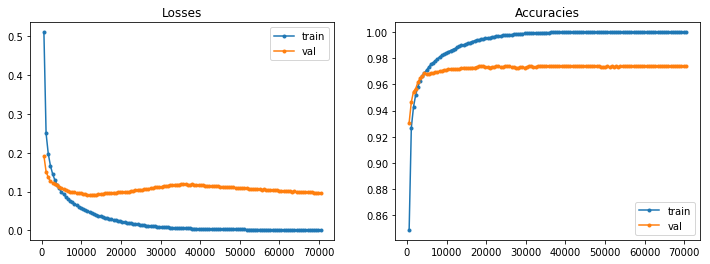

In [37]:
learning_rate_SGD = 0.0002
run_exp()

## 4. Report

First of all, the model's improvement in performance is proof that our implementation of the model, especially the forward and backward functions, is correct. This improvement in performance is observed across different models with different architectures.

The starting learning rate of 0.1 was noticed to be far too high, so much so that the model was entirely unable to learn. We suspect that this is because the high learning rate caused the weights to take on extreme values. With such extreme values all future gradients will be 0 (due to the nature of the sigmoid activation function), hence further learning was impossible. To resolve the issue we reduced the learning rate to give us the following set of hyperparameters:

* batch_size = 100
* max_epoch = 8
* init_std = 0.01
* learning_rate_SGD = 0.0005#0.1
* weight_decay = 0.001

With these hyperparameters we ran the five initial experiments provided in the template. Through these we discovered the following trends:

* Softmax loss performs better than Euclidean loss
* ReLU activation performs better than Sigmoid activation
* Model with an extra hidden layer performed better than without the extra hidden layer

The optimal architecture was hence determined to be as such:
* Fully connected layer 784 -> 64
* ReLU activation
* Fully connected layer 64 -> 32
* ReLU activation
* Fully connected layer 32 -> 10
* Softmax Cross Entropy Loss 

This gave test accuracy of 0.9623 which is already very good.

The first observation was that the model had not fully converged with 8 epochs. The validation accuracy was noticed to still be increasing. Hence to ensure convergence we tried 32 epochs instead, giving a slight improvement of test accuracy to 0.9731.

We then tried to increase the epochs to 128, giving us 0.9746 test accuracy and 1.0 training accuracy. This might suggest some overfitting, however the fact that the test accuracy increased slightly between 32 and 128 epochs shows that this is likely to not be the case. The lack of overfitting shows that our choice of weight decay hyperparameter is suitable. Just to be sure, we tried increasing weight decay to 0.002 - no significant difference was observed.

We also tried to reduce the learning rate to 0.0002, in the hopes that this would allow the model to converge to a lower local minimum. This did not have a significant difference either. The test accuracy was 0.9742. This is also the highest test accuracy we have observed thus far.


